In [1]:
import tensorflow as tf

import numpy as np

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [3]:
data

time      high       low      open  volumefrom     volumeto  \
0      1576144800   7219.93   7149.15   7170.18     1536.79  11041994.81   
1      1576148400   7208.36   7166.03   7166.14      785.11   5654607.43   
2      1576152000   7222.43   7194.87   7199.79      672.46   4855213.22   
3      1576155600   7211.80   7187.29   7199.97      807.61   5821087.81   
4      1576159200   7229.22   7152.84   7201.38     1606.06  11537799.57   
...           ...       ...       ...       ...         ...          ...   
10000  1612144800  33847.46  33257.39  33450.01     2066.49  69445570.35   
10001  1612148400  33779.76  33505.50  33675.45     1173.82  39473368.04   
10002  1612152000  33945.41  33404.87  33590.20     1430.06  48159838.72   
10003  1612155600  33907.89  33467.87  33576.82     1198.20  40319458.23   
10004  1612159200  33950.67  33739.63  33803.02      569.39  19288055.21   

          close conversionType conversionSymbol              timeUTC  
0       7166.14         direct              NaN  2019-12-12 19:00:00  
1       7199.79         direct              NaN  2019-12-12 20:00:00  
2       7199.97         direct              NaN  2019-12-12 21:00:00  
3       7201.38         direct              NaN  2019-12-12 22:00:00  
4       7173.50         direct              NaN  2019-12-12 23:00:00  
...         ...            ...              ...                  ...  
10000  33675.45         direct              NaN  2021-02-01 11:00:00  
10001  33590.20         direct              NaN  2021-02-01 12:00:00  
10002  33576.82         direct              NaN  2021-02-01 13:00:00  
10003  33803.02         direct              NaN  2021-02-01 14:00:00  
10004  33897.06         direct              NaN  2021-02-01 15:00:00  

[10005 rows x 10 columns]

In [54]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [55]:
np.max(values)

7859574300.0

In [56]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

8004 1000 1001


In [57]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [58]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

7812
808
809


In [59]:
print(trainX.shape)
print(trainY.shape)

(7812, 168, 6)
(7812, 24)


In [86]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

### LSTM

In [249]:
from tensorflow.keras.models import Model

first_input = Input(shape=(48,4))

in1=Bidirectional(LSTM(units =100 , return_sequences=False))(first_input)
#in1=RepeatVector(24)(in1)
in1= Dense(24)(in1)

model=Model(first_input, in1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_bilstm_mulstep_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [250]:
model.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               84000     
_________________________________________________________________
dense_44 (Dense)             (None, 24)                4824      
Total params: 88,824
Trainable params: 88,824
Non-trainable params: 0
_________________________________________________________________


In [251]:
trainY=np.reshape(trainY,(trainY.shape[0],trainY.shape[1],1))
valY=np.reshape(valY,(valY.shape[0],valY.shape[1],1))
testY=np.reshape(testY,(testY.shape[0],testY.shape[1],1))

In [252]:
history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7932 samples, validate on 928 samples
Epoch 1/100
7900/7932 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00001: val_loss improved from inf to 0.00048, saving model to saved_weights/btc_bilstm_mulstep_24.hdf5
7932/7932 [==============================] - 5s 662us/sample - loss: 0.0013 - val_loss: 4.8472e-04
Epoch 2/100
7900/7932 [============================>.] - ETA: 0s - loss: 6.0567e-05
Epoch 00002: val_loss improved from 0.00048 to 0.00037, saving model to saved_weights/btc_bilstm_mulstep_24.hdf5
7932/7932 [==============================] - 3s 324us/sample - loss: 6.0471e-05 - val_loss: 3.7137e-04
Epoch 3/100
7900/7932 [============================>.] - ETA: 0s - loss: 5.5604e-05
Epoch 00003: val_loss did not improve from 0.00037
7932/7932 [==============================] - 2s 311us/sample - loss: 5.5502e-05 - val_loss: 4.0915e-04
Epoch 4/100
7900/7932 [============================>.] - ETA: 0s - loss: 5.1269e-05
Epoch 00004: val_loss did not improve from 

7900/7932 [============================>.] - ETA: 0s - loss: 3.3297e-05
Epoch 00065: val_loss did not improve from 0.00016
7932/7932 [==============================] - 3s 321us/sample - loss: 3.3236e-05 - val_loss: 1.7636e-04
Epoch 66/100
7900/7932 [============================>.] - ETA: 0s - loss: 3.2899e-05
Epoch 00066: val_loss did not improve from 0.00016
7932/7932 [==============================] - 3s 320us/sample - loss: 3.2840e-05 - val_loss: 1.6957e-04
Epoch 67/100
7900/7932 [============================>.] - ETA: 0s - loss: 3.3464e-05
Epoch 00067: val_loss did not improve from 0.00016
7932/7932 [==============================] - 3s 320us/sample - loss: 3.3446e-05 - val_loss: 1.7590e-04
Epoch 68/100
7900/7932 [============================>.] - ETA: 0s - loss: 3.2640e-05
Epoch 00068: val_loss did not improve from 0.00016
7932/7932 [==============================] - 3s 321us/sample - loss: 3.2598e-05 - val_loss: 1.7019e-04
Epoch 69/100
7900/7932 [============================>.] -

Epoch 99/100
7900/7932 [============================>.] - ETA: 0s - loss: 3.1723e-05
Epoch 00099: val_loss did not improve from 0.00016
7932/7932 [==============================] - 3s 320us/sample - loss: 3.1680e-05 - val_loss: 1.7218e-04
Epoch 100/100
7900/7932 [============================>.] - ETA: 0s - loss: 3.1794e-05
Epoch 00100: val_loss did not improve from 0.00016
7932/7932 [==============================] - 3s 320us/sample - loss: 3.1780e-05 - val_loss: 1.7661e-04


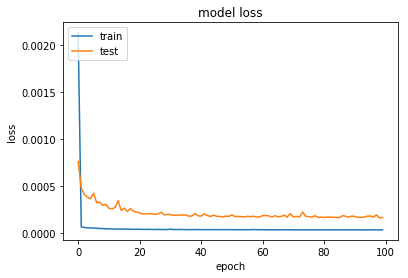

In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

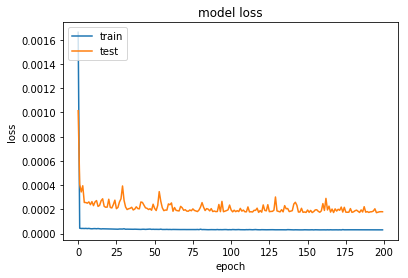

In [170]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [253]:
model.load_weights("saved_weights/btc_bilstm_mulstep_24.hdf5")

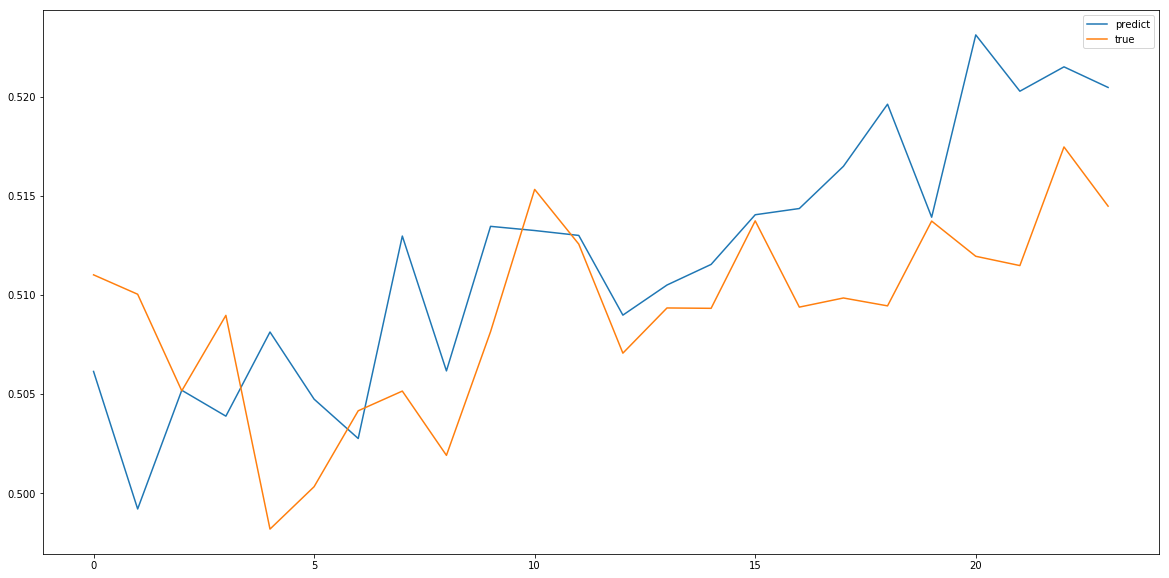

Test RMSE: 0.00590
Test MAE: 0.00475
Test MSE: 0.00003
Test RMSE: 224.47275
Test MAE: 180.75977


In [257]:
#saved_weights/btc_bilstm_mulstep_24.hdf5

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[9]
testy=testY[9]
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


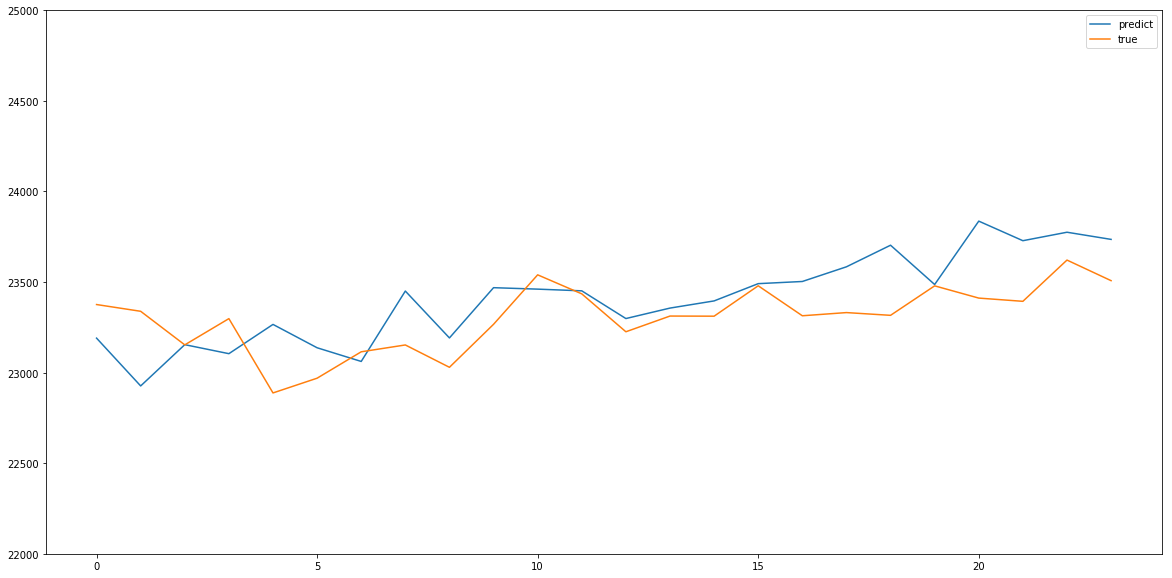

In [258]:

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='true')
pyplot.legend()

pyplot.ylim(22000,25000)
pyplot.show()

### LSTM-resCNN

In [87]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')


in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmrescnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [88]:
model.summary()

Model: "functional_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 168, 6)]     0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 168, 64)      18176       input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 168, 64)      12352       lstm_15[0][0]                    
__________________________________________________________________________________________________
conv1d_86 (Conv1D)              (None, 168, 64)      8256        conv1d_85[0][0]                  
______________________________________________________________________________________

In [89]:
history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0065
Epoch 00001: val_loss improved from inf to 0.00486, saving model to saved_weights\btc_lstmrescnn_mulstep.hdf5
79/79 [==============================] - 17s 211ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00002: val_loss improved from 0.00486 to 0.00116, saving model to saved_weights\btc_lstmrescnn_mulstep.hdf5
79/79 [==============================] - 25s 319ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 7.1653e-04
Epoch 00003: val_loss did not improve from 0.00116
79/79 [==============================] - 28s 354ms/step - loss: 7.1653e-04 - val_loss: 0.0017
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 5.1021e-04
Epoch 00004: val_loss improved from 0.00116 to 0.00091, saving model to saved_weights\btc_lstmrescnn_mulstep.hdf5
79/79 [==================

Epoch 34/100
79/79 [==============================] - ETA: 0s - loss: 2.1790e-04
Epoch 00034: val_loss did not improve from 0.00031
79/79 [==============================] - 21s 272ms/step - loss: 2.1790e-04 - val_loss: 6.1369e-04
Epoch 35/100
79/79 [==============================] - ETA: 0s - loss: 2.1431e-04
Epoch 00035: val_loss did not improve from 0.00031
79/79 [==============================] - 19s 245ms/step - loss: 2.1431e-04 - val_loss: 0.0011
Epoch 36/100
79/79 [==============================] - ETA: 0s - loss: 2.2181e-04
Epoch 00036: val_loss improved from 0.00031 to 0.00030, saving model to saved_weights\btc_lstmrescnn_mulstep.hdf5
79/79 [==============================] - 21s 265ms/step - loss: 2.2181e-04 - val_loss: 3.0257e-04
Epoch 37/100
79/79 [==============================] - ETA: 0s - loss: 2.1410e-04
Epoch 00037: val_loss did not improve from 0.00030
79/79 [==============================] - 24s 300ms/step - loss: 2.1410e-04 - val_loss: 6.6038e-04
Epoch 38/100
79/79 [=

KeyboardInterrupt: 

In [90]:
model.load_weights("saved_weights/btc_lstmrescnn_mulstep.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


C:\Users\chlgy\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\chlgy\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


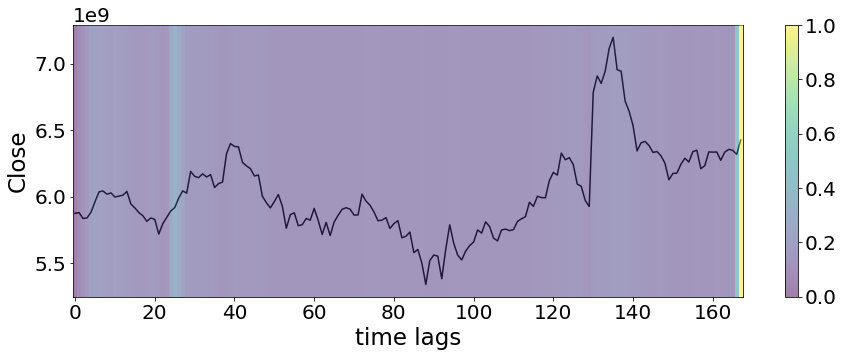

In [91]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=800
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')

y_label_list = [2,4,6,8]

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


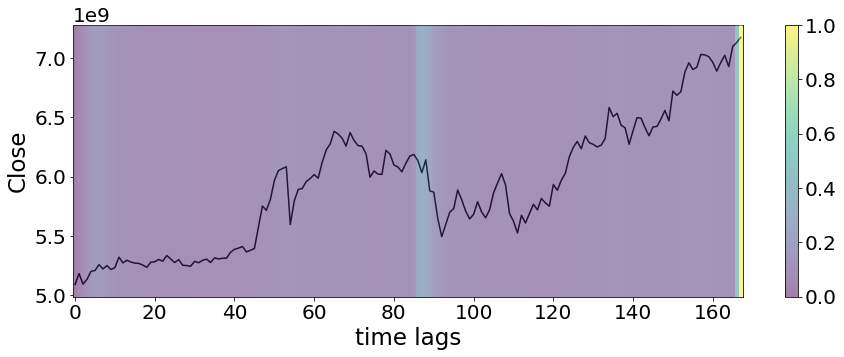

In [92]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*10
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

(1, 168, 6)


C:\Users\chlgy\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\chlgy\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 720x720 with 0 Axes>

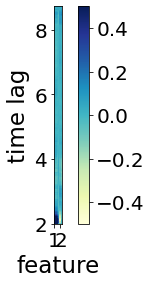

In [93]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[5], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(10,10))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 168]
#x_label_list = [1,2,3,4,5,6,7,8,9]
#y_label_list = [24,20,15,10,5,0]
#ax.set_yticks([0,5,10,15,20,24])

#ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6, 0 , 168], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [42]:
from math import *
from sklearn.metrics import *

non_aug_rm=[]
non_aug_ma=[]
non_aug_mp=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    
    mae = mean_absolute_error(testy, yhat)
    
    mape=mean_absolute_percentage_error(testy, np.array(yhat))
    print('Test MAPE: %.5f' % mape)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    non_aug_rm.append(rmse)
    non_aug_ma.append(mae)
    non_aug_mp.append(mape)


print(np.mean(non_aug_rm),np.std(non_aug_rm))
print(np.mean(non_aug_ma),np.std(non_aug_ma))
print(np.mean(non_aug_mp),np.std(non_aug_mp))

Test MAPE: 0.01793
Test MAE: 0.01322
Test RMSE: 0.01758
Test MAPE: 0.03127
Test MAE: 0.01889
Test RMSE: 0.02112
Test MAPE: 0.03270
Test MAE: 0.01662
Test RMSE: 0.01841
Test MAPE: 0.02126
Test MAE: 0.01853
Test RMSE: 0.02164
Test MAPE: 0.07251
Test MAE: 0.05214
Test RMSE: 0.05712
Test MAPE: 0.02357
Test MAE: 0.01418
Test RMSE: 0.01652
Test MAPE: 0.01702
Test MAE: 0.01283
Test RMSE: 0.01529
Test MAPE: 0.02469
Test MAE: 0.01908
Test RMSE: 0.02484
Test MAPE: 0.03726
Test MAE: 0.03133
Test RMSE: 0.03827
Test MAPE: 0.05668
Test MAE: 0.04989
Test RMSE: 0.05779
Test MAPE: 0.08322
Test MAE: 0.06505
Test RMSE: 0.07169
Test MAPE: 0.06307
Test MAE: 0.05112
Test RMSE: 0.05819
Test MAPE: 0.04924
Test MAE: 0.03898
Test RMSE: 0.04796
Test MAPE: 0.02777
Test MAE: 0.02105
Test RMSE: 0.02461
Test MAPE: 0.06149
Test MAE: 0.03755
Test RMSE: 0.04277
0.03558538816841979 0.018289607944585902
0.030697567 0.016637037
0.041311573 0.02067752


## LSTM-CNN

In [46]:
from tensorflow.keras.models import Model

first_input = Input(shape=(48,4))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmcnn_mulstep_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [47]:
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 48, 64)            17664     
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 48, 64)            8256      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 48, 64)            8256      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 48, 64)            4160      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 48, 64)            8256      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 48, 64)          

In [48]:
history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00001: val_loss improved from inf to 0.00051, saving model to saved_weights\btc_lstmcnn_mulstep_24.hdf5
80/80 [==============================] - 17s 207ms/step - loss: 0.0015 - val_loss: 5.1214e-04
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 2.1037e-04
Epoch 00002: val_loss did not improve from 0.00051
80/80 [==============================] - 15s 186ms/step - loss: 2.1037e-04 - val_loss: 5.4536e-04
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 1.6950e-04
Epoch 00003: val_loss improved from 0.00051 to 0.00048, saving model to saved_weights\btc_lstmcnn_mulstep_24.hdf5
80/80 [==============================] - 18s 227ms/step - loss: 1.6950e-04 - val_loss: 4.8441e-04
Epoch 4/100
80/80 [==============================] - ETA: 0s - loss: 1.6458e-04
Epoch 00004: val_loss did not improve from 0.00048
80/80 [==============================] - 16s 195ms/step - loss: 1.64

Epoch 34/100
80/80 [==============================] - ETA: 0s - loss: 5.7865e-05
Epoch 00034: val_loss did not improve from 0.00021
80/80 [==============================] - 11s 132ms/step - loss: 5.7865e-05 - val_loss: 2.3310e-04
Epoch 35/100
80/80 [==============================] - ETA: 0s - loss: 6.2285e-05
Epoch 00035: val_loss did not improve from 0.00021
80/80 [==============================] - 11s 133ms/step - loss: 6.2285e-05 - val_loss: 2.1797e-04
Epoch 36/100
80/80 [==============================] - ETA: 0s - loss: 5.3722e-05
Epoch 00036: val_loss did not improve from 0.00021
80/80 [==============================] - 11s 133ms/step - loss: 5.3722e-05 - val_loss: 2.3028e-04
Epoch 37/100
80/80 [==============================] - ETA: 0s - loss: 5.3782e-05
Epoch 00037: val_loss did not improve from 0.00021
80/80 [==============================] - 12s 145ms/step - loss: 5.3782e-05 - val_loss: 2.1846e-04
Epoch 38/100
80/80 [==============================] - ETA: 0s - loss: 6.4730e-05

KeyboardInterrupt: 

In [49]:

model.load_weights("saved_weights/btc_lstmcnn_mulstep_24.hdf5")

In [50]:
from math import *
from sklearn.metrics import *

non_aug_rm=[]
non_aug_ma=[]
non_aug_mp=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    
    mae = mean_absolute_error(testy, yhat)
    
    mape=mean_absolute_percentage_error(testy, np.array(yhat))
    print('Test MAPE: %.5f' % mape)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    non_aug_rm.append(rmse)
    non_aug_ma.append(mae)
    non_aug_mp.append(mape)


print(np.mean(non_aug_rm),np.std(non_aug_rm))
print(np.mean(non_aug_ma),np.std(non_aug_ma))
print(np.mean(non_aug_mp),np.std(non_aug_mp))

Test MAPE: 0.03209
Test MAE: 0.02377
Test RMSE: 0.02900
Test MAPE: 0.01705
Test MAE: 0.01030
Test RMSE: 0.01265
Test MAPE: 0.02826
Test MAE: 0.01435
Test RMSE: 0.01643
Test MAPE: 0.06183
Test MAE: 0.05380
Test RMSE: 0.05535
Test MAPE: 0.03114
Test MAE: 0.02228
Test RMSE: 0.02739
Test MAPE: 0.01583
Test MAE: 0.00954
Test RMSE: 0.01136
Test MAPE: 0.03962
Test MAE: 0.02996
Test RMSE: 0.03094
Test MAPE: 0.06361
Test MAE: 0.04885
Test RMSE: 0.05148
Test MAPE: 0.03614
Test MAE: 0.03127
Test RMSE: 0.03773
Test MAPE: 0.10335
Test MAE: 0.09020
Test RMSE: 0.09460
Test MAPE: 0.11549
Test MAE: 0.08975
Test RMSE: 0.09358
Test MAPE: 0.10648
Test MAE: 0.08555
Test RMSE: 0.08849
Test MAPE: 0.04104
Test MAE: 0.03357
Test RMSE: 0.03905
Test MAPE: 0.04004
Test MAE: 0.03092
Test RMSE: 0.03489
Test MAPE: 0.07029
Test MAE: 0.04277
Test RMSE: 0.04682
0.044650993047860604 0.02684579221645528
0.04112365 0.026674977
0.053484466 0.031370312


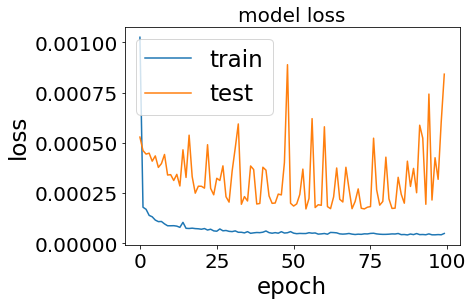

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
len(testX)//24

38

In [109]:
aug_rm=[]
aug_ma=[]
for k in range(38):

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    aug_rm.append(rmse)
    aug_ma.append(mae)

    
print(np.mean(aug_rm))
print(np.mean(aug_ma))

Test MAE: 0.01662
Test RMSE: 0.01841
Test MAE: 0.00630
Test RMSE: 0.00860
Test MAE: 0.00603
Test RMSE: 0.00794
Test MAE: 0.03755
Test RMSE: 0.04277
Test MAE: 0.01889
Test RMSE: 0.02112
Test MAE: 0.01418
Test RMSE: 0.01652
Test MAE: 0.01544
Test RMSE: 0.01757
Test MAE: 0.01530
Test RMSE: 0.01710
Test MAE: 0.00943
Test RMSE: 0.01157
Test MAE: 0.01060
Test RMSE: 0.01269
Test MAE: 0.06505
Test RMSE: 0.07169
Test MAE: 0.03348
Test RMSE: 0.04157
Test MAE: 0.01322
Test RMSE: 0.01758
Test MAE: 0.05112
Test RMSE: 0.05819
Test MAE: 0.04989
Test RMSE: 0.05779
Test MAE: 0.05715
Test RMSE: 0.06404
Test MAE: 0.03991
Test RMSE: 0.04302
Test MAE: 0.04605
Test RMSE: 0.05092
Test MAE: 0.04834
Test RMSE: 0.06259
Test MAE: 0.03898
Test RMSE: 0.04796
Test MAE: 0.04410
Test RMSE: 0.05016
Test MAE: 0.07149
Test RMSE: 0.08143
Test MAE: 0.03578
Test RMSE: 0.03938
Test MAE: 0.02571
Test RMSE: 0.02937
Test MAE: 0.03133
Test RMSE: 0.03827
Test MAE: 0.03080
Test RMSE: 0.03607
Test MAE: 0.01853
Test RMSE: 0.02164
T

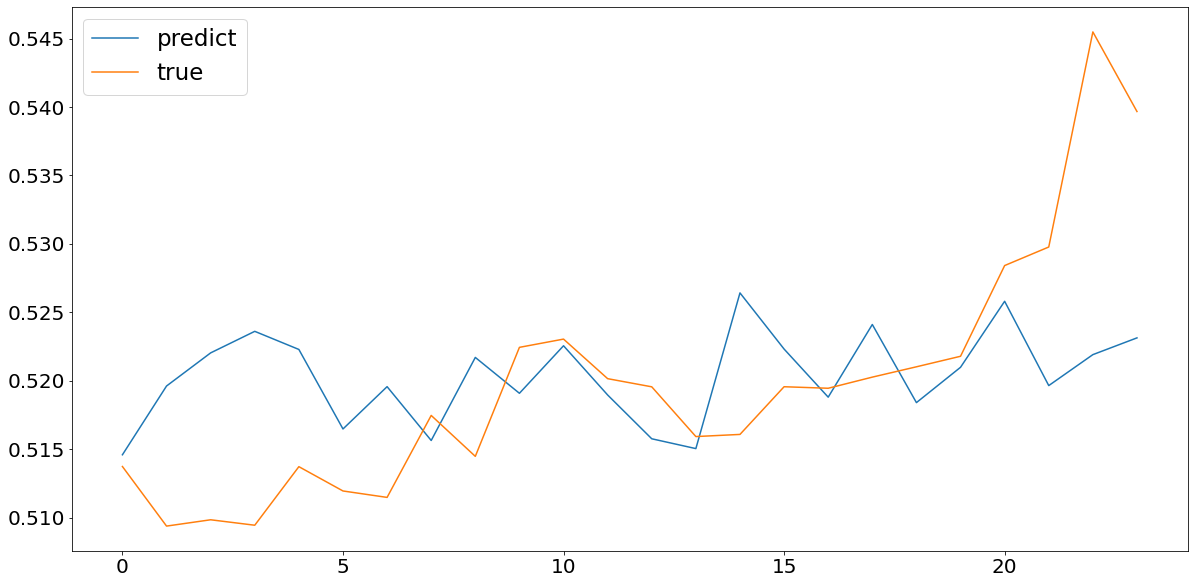

Test RMSE: 0.00860
Test MAE: 0.00630
Test MSE: 0.00007
Test RMSE: 326.82326
Test MAE: 239.60246


In [118]:
##saved_weights/btc_lstmcnn_mulstep.hdf5

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*1]
testy=testY[24*1]
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


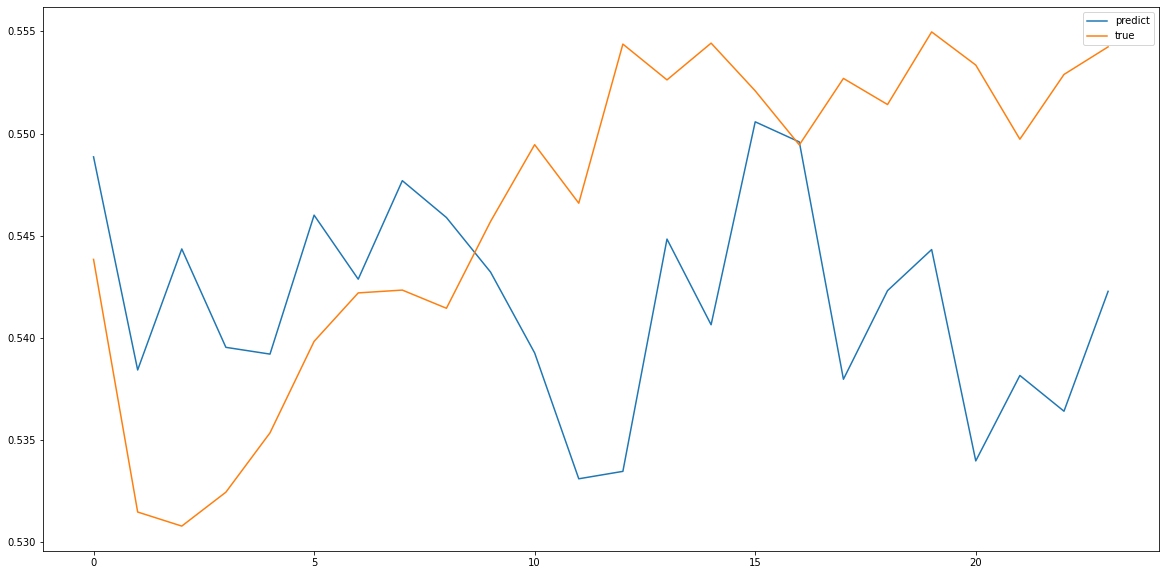

Test RMSE: 0.01066
Test MAE: 0.00905
Test MSE: 0.00011
Test RMSE: 405.07958
Test MAE: 343.94400


In [28]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*2]
testy=testY[24*2]
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [29]:
d=pd.DataFrame()
d['yhat_inverse']=yhat_inverse.reshape(1,-1)[0]
d.to_excel('btc_lstmcnn_predict.xlsx')

In [30]:
yhat = model.predict([testX])
testy1=testY[24*1]
testy2=testY[24*2]

testY_inverse1=testy1*(np.max(values)-np.min(values))+np.min(values)
testY_inverse2=testy2*(np.max(values)-np.min(values))+np.min(values)

In [31]:
d=pd.DataFrame()
d['true']=np.append(testY_inverse1,testY_inverse2)
d.to_excel('btc_true.xlsx')
d

true
0   23479.136719
1   23313.662109
2   23331.197266
3   23316.062500
4   23478.726562
5   23411.208984
6   23393.359375
7   23621.005859
8   23507.365234
9   23810.115234
10  23833.025391
11  23723.142578
12  23700.486328
13  23562.322266
14  23568.281250
15  23700.722656
16  23696.496094
17  23727.396484
18  23756.085938
19  23785.337891
20  24037.302734
21  24088.820312
22  24686.255859
23  24465.142578
24  24623.728516
25  24154.025391
26  24127.867188
27  24190.896484
28  24301.228516
29  24471.304688
30  24561.421875
31  24566.646484
32  24532.845703
33  24694.175781
34  24837.033203
35  24728.212891
36  25024.021484
37  24957.460938
38  25025.785156
39  24937.099609
40  24836.574219
41  24960.175781
42  24911.636719
43  25046.656250
44  24985.035156
45  24847.177734
46  24967.552734
47  25018.847656

In [60]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


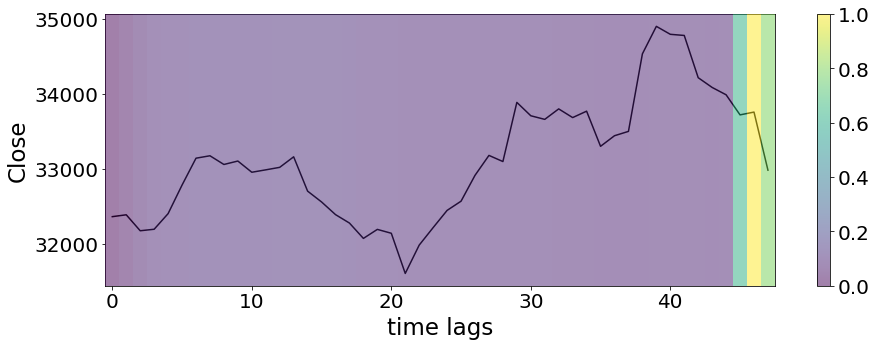

In [64]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=800
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


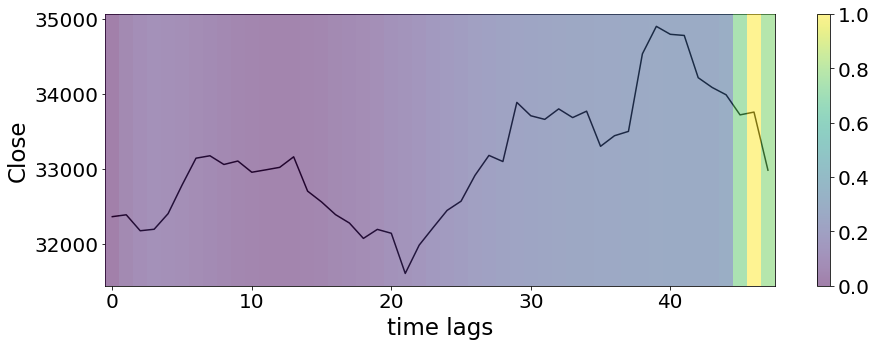

In [61]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=800
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

# plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='true')
pyplot.legend()

pyplot.ylim(22500,25000)
pyplot.show()

(1, 8, 64)


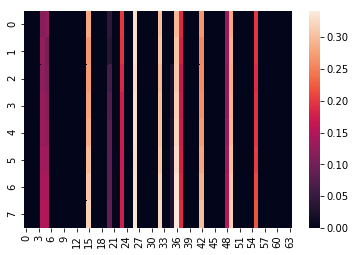

lstm/kernel:0 (4, 600)
[[ 0.01687572  0.0040791  -0.08175524 ...  0.04417311 -0.01075847
   0.0937482 ]
 [-0.03428883  0.01214882 -0.07327168 ... -0.06912688  0.04183797
   0.08552262]
 [ 0.06907797 -0.05080423 -0.02479464 ...  0.06218564  0.05919589
  -0.02392823]
 [-0.0722043   0.12003319  0.01314483 ... -0.06392354  0.07464996
   0.01499266]]
lstm/recurrent_kernel:0 (150, 600)
[[ 0.01708856  0.00328133 -0.04445638 ...  0.03488209 -0.00731788
  -0.00503872]
 [ 0.02365706  0.02334376 -0.01118977 ...  0.04830309  0.00949042
   0.00613973]
 [ 0.01134775 -0.00664546  0.03082429 ...  0.02392985  0.09192701
   0.00545367]
 ...
 [ 0.03519694  0.03230287 -0.01804652 ...  0.05008288  0.01597028
  -0.01964789]
 [-0.0349279  -0.03322744 -0.0163685  ... -0.05000567  0.02924403
  -0.04158839]
 [-0.01288916  0.00767069 -0.03859486 ...  0.00952313  0.02103245
  -0.01390667]]
lstm/bias:0 (600,)
[-0.03001484  0.13663606 -0.0414154   0.02097205  0.15053552  0.01872304
  0.27548662 -0.04246313 -0.05340

In [26]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = 295
output_final = model.predict(np.array([valX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[2].output)
output = intermediate_layer_model.predict(np.array([valX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

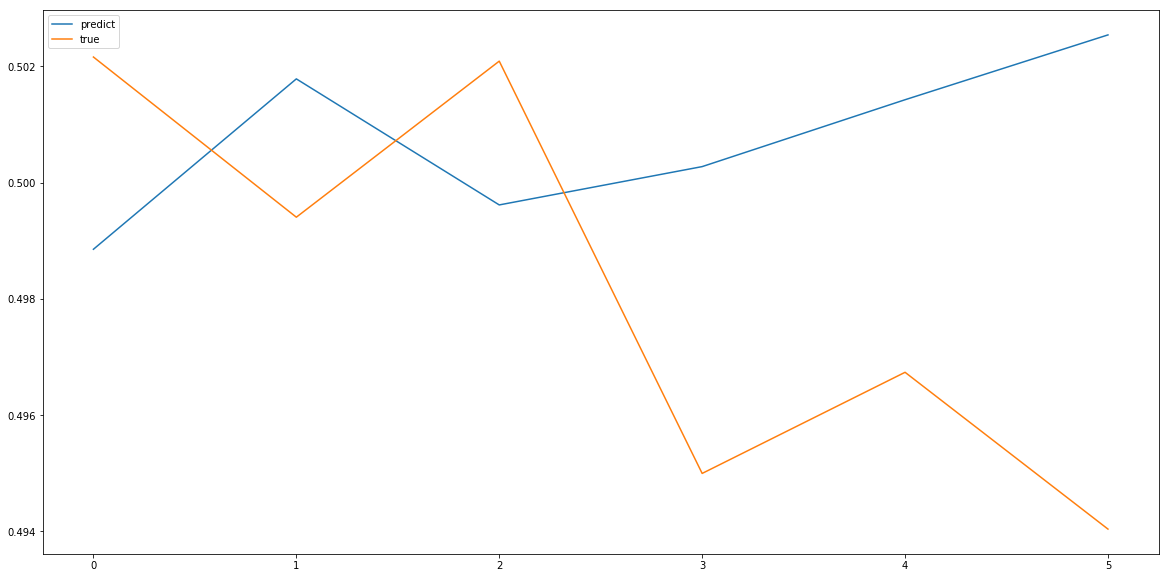

Test RMSE: 0.00492
Test MAE: 0.00444
Test MSE: 0.00002
Test RMSE: 186.87883
Test MAE: 168.80794


In [74]:
### lstm(150)-1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[1]
testy=testY[1]
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### 1D-CNN

In [218]:

first_input = Input(shape=(48,4))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/btc_1dcnn_multistep_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model

# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 48, 64)            1344      
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 48, 64)            12352     
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 48, 64)            4160      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 24, 64)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 24)                368

In [449]:
first_input = Input(shape=(48,4))

in1=Conv1D(filters=128, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=128, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=128, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/btc_1dcnn_multi_exp.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 48, 128)           3712      
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 48, 128)           82048     
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 48, 128)           16512     
_________________________________________________________________
extractor (MaxPooling1D)     (None, 24, 128)           0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 100)               307

In [450]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7932 samples, validate on 928 samples
Epoch 1/200
7600/7932 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00048, saving model to saved_weights/btc_1dcnn_multi_exp.hdf5
7932/7932 [==============================] - 1s 173us/sample - loss: 0.0011 - val_loss: 4.7753e-04
Epoch 2/200
7500/7932 [===========================>..] - ETA: 0s - loss: 7.2626e-05
Epoch 00002: val_loss did not improve from 0.00048
7932/7932 [==============================] - 1s 127us/sample - loss: 7.1806e-05 - val_loss: 4.9412e-04
Epoch 3/200
7500/7932 [===========================>..] - ETA: 0s - loss: 6.1256e-05
Epoch 00003: val_loss improved from 0.00048 to 0.00043, saving model to saved_weights/btc_1dcnn_multi_exp.hdf5
7932/7932 [==============================] - 1s 132us/sample - loss: 6.1978e-05 - val_loss: 4.3075e-04
Epoch 4/200
7500/7932 [===========================>..] - ETA: 0s - loss: 5.5234e-05
Epoch 00004: val_loss improved from 0.00043 to 

Epoch 33/200
7600/7932 [===========================>..] - ETA: 0s - loss: 3.5349e-05
Epoch 00033: val_loss did not improve from 0.00020
7932/7932 [==============================] - 1s 127us/sample - loss: 3.5390e-05 - val_loss: 2.1122e-04
Epoch 34/200
7600/7932 [===========================>..] - ETA: 0s - loss: 3.3910e-05
Epoch 00034: val_loss did not improve from 0.00020
7932/7932 [==============================] - 1s 127us/sample - loss: 3.3806e-05 - val_loss: 2.0240e-04
Epoch 35/200
7600/7932 [===========================>..] - ETA: 0s - loss: 3.2502e-05
Epoch 00035: val_loss did not improve from 0.00020
7932/7932 [==============================] - 1s 127us/sample - loss: 3.2537e-05 - val_loss: 4.6690e-04
Epoch 36/200
7600/7932 [===========================>..] - ETA: 0s - loss: 3.5391e-05
Epoch 00036: val_loss did not improve from 0.00020
7932/7932 [==============================] - 1s 127us/sample - loss: 3.5146e-05 - val_loss: 2.1693e-04
Epoch 37/200
7600/7932 [====================

Epoch 67/200
7600/7932 [===========================>..] - ETA: 0s - loss: 3.2988e-05
Epoch 00067: val_loss did not improve from 0.00017
7932/7932 [==============================] - 1s 127us/sample - loss: 3.2957e-05 - val_loss: 2.6812e-04
Epoch 68/200
7500/7932 [===========================>..] - ETA: 0s - loss: 2.9661e-05
Epoch 00068: val_loss did not improve from 0.00017
7932/7932 [==============================] - 1s 127us/sample - loss: 2.9633e-05 - val_loss: 1.9849e-04
Epoch 69/200
7600/7932 [===========================>..] - ETA: 0s - loss: 2.8873e-05
Epoch 00069: val_loss did not improve from 0.00017
7932/7932 [==============================] - 1s 127us/sample - loss: 2.8818e-05 - val_loss: 1.7885e-04
Epoch 70/200
7600/7932 [===========================>..] - ETA: 0s - loss: 2.9114e-05
Epoch 00070: val_loss did not improve from 0.00017
7932/7932 [==============================] - 1s 127us/sample - loss: 2.9236e-05 - val_loss: 3.3856e-04
Epoch 71/200
7500/7932 [====================

Epoch 101/200
7500/7932 [===========================>..] - ETA: 0s - loss: 2.9380e-05
Epoch 00101: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 127us/sample - loss: 2.8990e-05 - val_loss: 1.5989e-04
Epoch 102/200
7600/7932 [===========================>..] - ETA: 0s - loss: 2.9277e-05
Epoch 00102: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 127us/sample - loss: 2.9306e-05 - val_loss: 1.8918e-04
Epoch 103/200
7600/7932 [===========================>..] - ETA: 0s - loss: 2.8562e-05
Epoch 00103: val_loss improved from 0.00016 to 0.00016, saving model to saved_weights/btc_1dcnn_multi_exp.hdf5
7932/7932 [==============================] - 1s 131us/sample - loss: 2.8381e-05 - val_loss: 1.5920e-04
Epoch 104/200
7600/7932 [===========================>..] - ETA: 0s - loss: 2.8207e-05
Epoch 00104: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 127us/sample - loss: 2.8544e-05 - v

Epoch 135/200
7500/7932 [===========================>..] - ETA: 0s - loss: 2.8118e-05
Epoch 00135: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 127us/sample - loss: 2.8543e-05 - val_loss: 1.8938e-04
Epoch 136/200
7600/7932 [===========================>..] - ETA: 0s - loss: 2.6478e-05
Epoch 00136: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 126us/sample - loss: 2.6798e-05 - val_loss: 1.6966e-04
Epoch 137/200
7500/7932 [===========================>..] - ETA: 0s - loss: 2.6792e-05
Epoch 00137: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 127us/sample - loss: 2.7129e-05 - val_loss: 1.6476e-04
Epoch 138/200
7500/7932 [===========================>..] - ETA: 0s - loss: 2.8947e-05
Epoch 00138: val_loss did not improve from 0.00016
7932/7932 [==============================] - 1s 127us/sample - loss: 2.8833e-05 - val_loss: 1.5972e-04
Epoch 139/200
7600/7932 [===============

In [451]:
model.load_weights("saved_weights/btc_1dcnn_multi_exp.hdf5")

In [452]:
aug_rm=[]
aug_ma=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    aug_rm.append(rmse)
    aug_ma.append(mae)

    
print(np.mean(aug_rm))
print(np.mean(aug_ma))

Test MAE: 0.01550
Test RMSE: 0.02045
Test MAE: 0.02206
Test RMSE: 0.02508
Test MAE: 0.01879
Test RMSE: 0.02164
Test MAE: 0.03883
Test RMSE: 0.04203
Test MAE: 0.05718
Test RMSE: 0.06249
Test MAE: 0.01213
Test RMSE: 0.01466
Test MAE: 0.00922
Test RMSE: 0.01089
Test MAE: 0.01637
Test RMSE: 0.02024
Test MAE: 0.06405
Test RMSE: 0.07524
Test MAE: 0.03246
Test RMSE: 0.03877
Test MAE: 0.03975
Test RMSE: 0.04461
Test MAE: 0.04834
Test RMSE: 0.05211
Test MAE: 0.02992
Test RMSE: 0.03368
Test MAE: 0.01515
Test RMSE: 0.01892
Test MAE: 0.03901
Test RMSE: 0.04303
0.0349218323437611
0.030583637


In [434]:
j

[12, 4, 0, 26, 29, 5, 31, 30, 24, 14, 10, 13, 19, 32, 3]

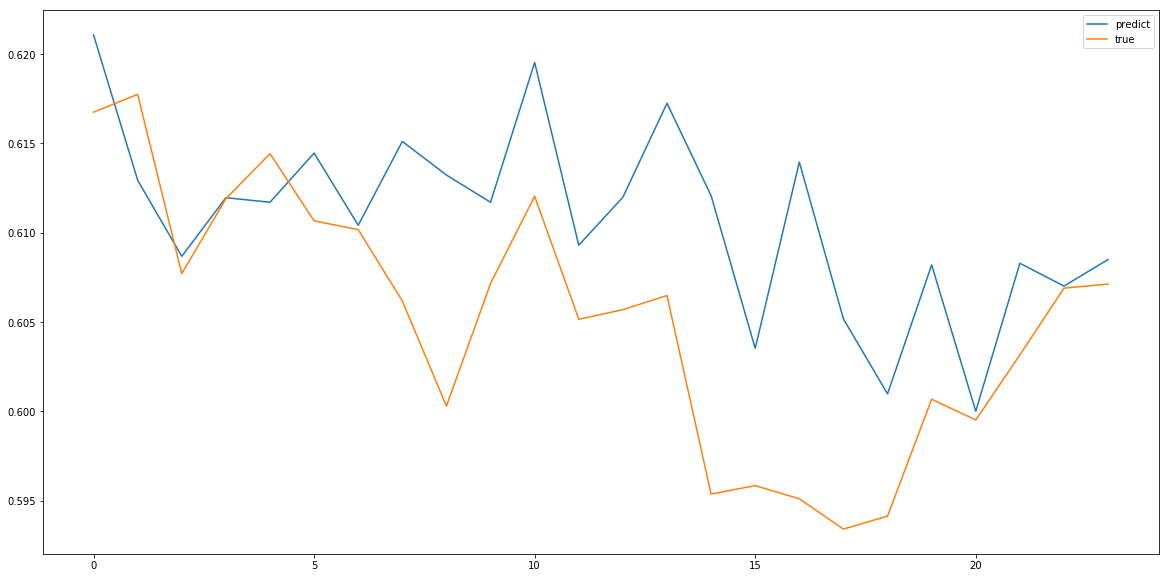

Test RMSE: 0.00797
Test MAE: 0.00619
Test MSE: 0.00006
Test RMSE: 302.90428
Test MAE: 235.14925


In [435]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*5]
testy=testY[24*5]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


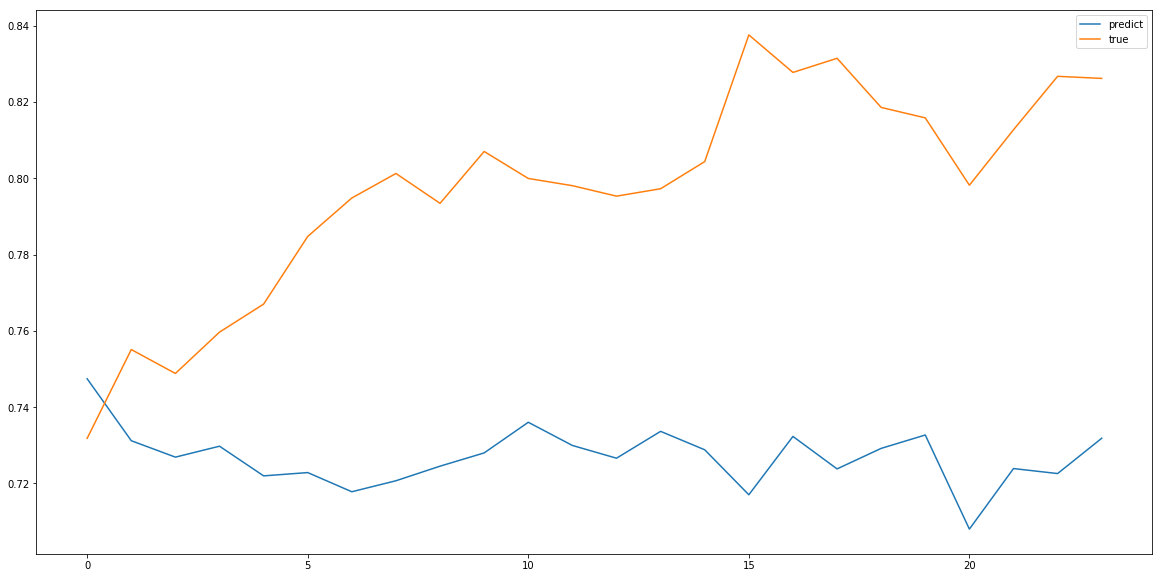

Test RMSE: 0.07652
Test MAE: 0.07155
Test MSE: 0.00586
Test RMSE: 2908.92334
Test MAE: 2719.87109


In [441]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*13]
testy=testY[24*13]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


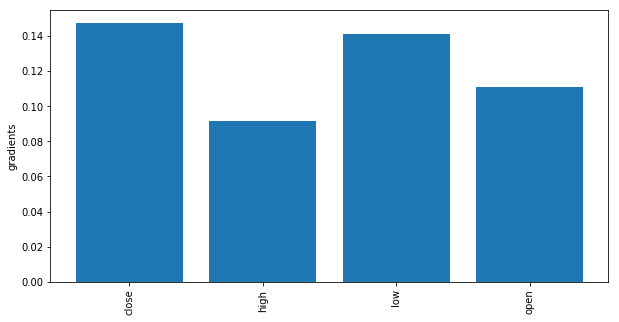

In [438]:
columns='close','high','low','open'
X_test=testX.copy()
id_=24*5
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

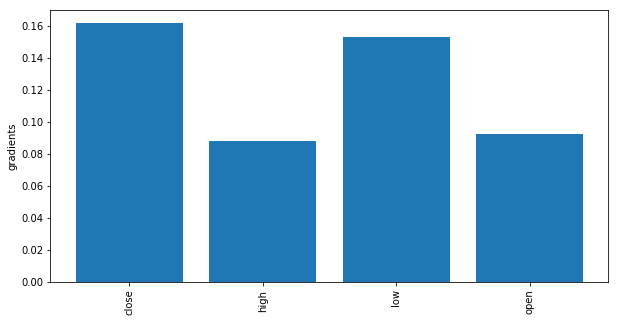

In [442]:
columns='close','high','low','open'
X_test=testX.copy()
id_=24*13
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [443]:
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([34216., 33906., 32952., 33204., 33078., 33067., 34048., 33898.,
       33451., 33364., 33168., 33521., 33810., 33877., 33631., 33132.,
       33660., 32394., 32339., 31269., 30527., 31021., 31524., 31674.,
       32428., 32036., 31570., 31250., 31440., 31949., 31535., 31293.,
       31620., 32310., 32714., 33094., 32636., 31473., 31155., 30678.,
       31399., 31083., 31467., 31847., 31619., 32083., 31905., 31769.],
      dtype=float32)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


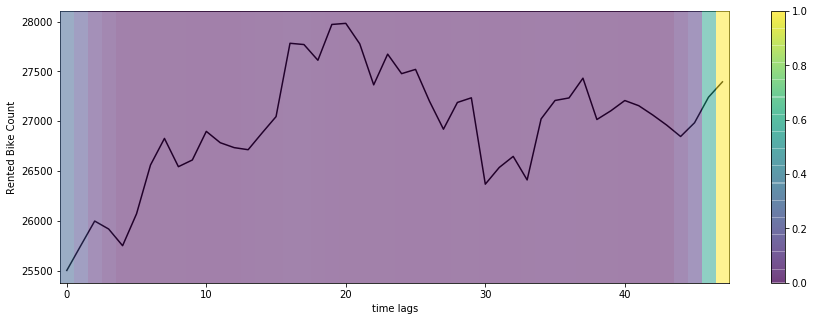

In [440]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


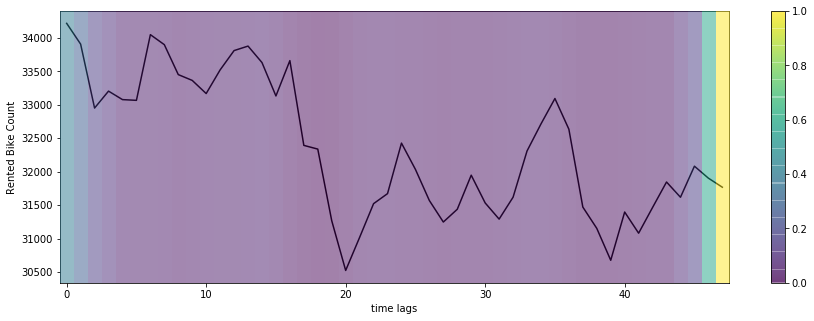

In [444]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

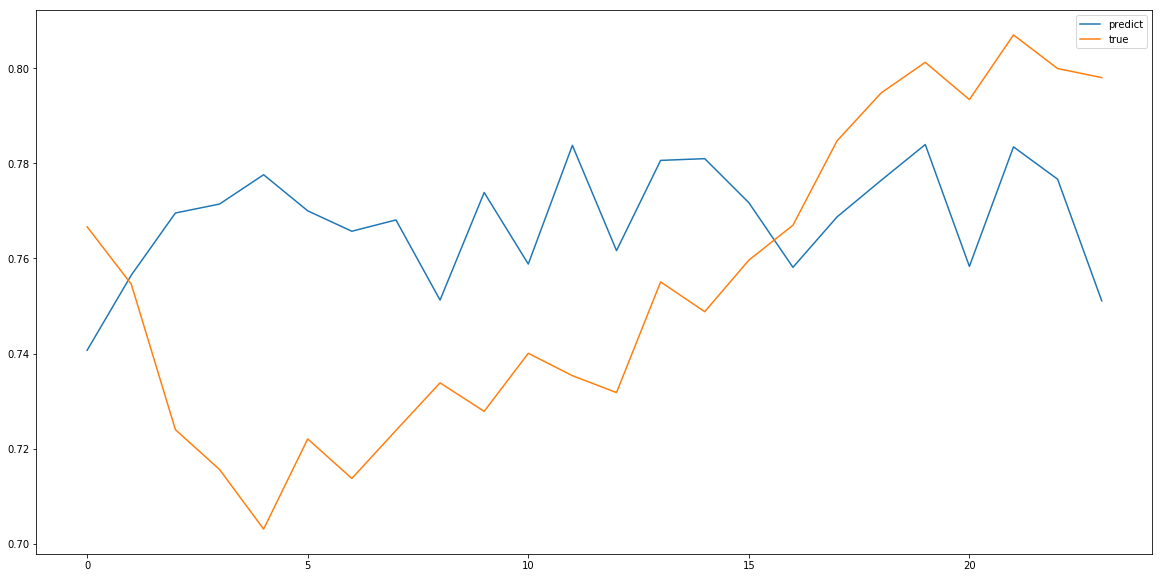

Test RMSE: 0.03635
Test MAE: 0.03198
Test MSE: 0.00132
Test RMSE: 1381.92262
Test MAE: 1215.60022


In [223]:
from matplotlib import pyplot
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[300]
testy=testY[300]
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### timedistributed 1dcnn

In [383]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [375]:
trainY=np.reshape(trainY,(trainY.shape[0],1,trainY.shape[1],1))
valY=np.reshape(valY,(valY.shape[0],1,valY.shape[1],1))
testY=np.reshape(testY,(testY.shape[0],1,testY.shape[1],1))

In [112]:
trainY.shape

(7986, 1, 6, 1)

In [148]:
first_input = Input(shape=(72,4))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=RepeatVector(24)(in1)
#in1=Dense(100, activation='relu')(in1)
out=TimeDistributed(Dense(1))(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/btc_time_1dcnn_multistep_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model

# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 72, 4)]           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 72, 64)            1344      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 72, 64)            4160      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 36, 64)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 2304)              0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 24, 2304)          0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 24, 1)             230

In [149]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7908 samples, validate on 904 samples
Epoch 1/200
7600/7908 [===========================>..] - ETA: 0s - loss: 0.0010
Epoch 00001: val_loss improved from inf to 0.00058, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 171us/sample - loss: 9.9352e-04 - val_loss: 5.7704e-04
Epoch 2/200
7600/7908 [===========================>..] - ETA: 0s - loss: 6.2667e-05
Epoch 00002: val_loss improved from 0.00058 to 0.00052, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 115us/sample - loss: 6.1831e-05 - val_loss: 5.1664e-04
Epoch 3/200
7600/7908 [===========================>..] - ETA: 0s - loss: 5.3614e-05
Epoch 00003: val_loss did not improve from 0.00052
7908/7908 [==============================] - 1s 112us/sample - loss: 5.3061e-05 - val_loss: 5.4628e-04
Epoch 4/200
7600/7908 [===========================>..] - ETA: 0s - loss: 4.7158e-05
Epoch 00004: val_loss did n

7600/7908 [===========================>..] - ETA: 0s - loss: 3.3306e-05
Epoch 00032: val_loss improved from 0.00036 to 0.00033, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 115us/sample - loss: 3.3537e-05 - val_loss: 3.3477e-04
Epoch 33/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.2654e-05
Epoch 00033: val_loss did not improve from 0.00033
7908/7908 [==============================] - 1s 115us/sample - loss: 3.2820e-05 - val_loss: 4.0370e-04
Epoch 34/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.3817e-05
Epoch 00034: val_loss did not improve from 0.00033
7908/7908 [==============================] - 1s 112us/sample - loss: 3.3456e-05 - val_loss: 3.4852e-04
Epoch 35/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.4025e-05
Epoch 00035: val_loss did not improve from 0.00033
7908/7908 [==============================] - 1s 114us/sample - loss: 3.4044e-05 - val_loss: 

Epoch 96/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.1548e-05
Epoch 00096: val_loss improved from 0.00022 to 0.00021, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 115us/sample - loss: 3.1515e-05 - val_loss: 2.1260e-04
Epoch 97/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.0139e-05
Epoch 00097: val_loss improved from 0.00021 to 0.00021, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 114us/sample - loss: 2.9900e-05 - val_loss: 2.0540e-04
Epoch 98/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.9850e-05
Epoch 00098: val_loss did not improve from 0.00021
7908/7908 [==============================] - 1s 112us/sample - loss: 2.9999e-05 - val_loss: 2.1440e-04
Epoch 99/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.0268e-05
Epoch 00099: val_loss did not improve from 0.00021
7908/7908 [

7908/7908 [==============================] - 1s 114us/sample - loss: 2.9140e-05 - val_loss: 1.8822e-04
Epoch 129/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.8819e-05
Epoch 00129: val_loss did not improve from 0.00019
7908/7908 [==============================] - 1s 113us/sample - loss: 2.8988e-05 - val_loss: 2.0828e-04
Epoch 130/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.8793e-05
Epoch 00130: val_loss did not improve from 0.00019
7908/7908 [==============================] - 1s 114us/sample - loss: 2.8845e-05 - val_loss: 2.5660e-04
Epoch 131/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.9748e-05
Epoch 00131: val_loss did not improve from 0.00019
7908/7908 [==============================] - 1s 113us/sample - loss: 2.9959e-05 - val_loss: 2.2180e-04
Epoch 132/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.9479e-05
Epoch 00132: val_loss did not improve from 0.00019
7908/7908 [=============================

7600/7908 [===========================>..] - ETA: 0s - loss: 2.9451e-05
Epoch 00195: val_loss improved from 0.00018 to 0.00017, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 115us/sample - loss: 2.9399e-05 - val_loss: 1.6884e-04
Epoch 196/200
7600/7908 [===========================>..] - ETA: 0s - loss: 3.0012e-05
Epoch 00196: val_loss did not improve from 0.00017
7908/7908 [==============================] - 1s 115us/sample - loss: 2.9761e-05 - val_loss: 1.7591e-04
Epoch 197/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.9344e-05
Epoch 00197: val_loss improved from 0.00017 to 0.00017, saving model to saved_weights/btc_time_1dcnn_multistep_24.hdf5
7908/7908 [==============================] - 1s 115us/sample - loss: 2.9338e-05 - val_loss: 1.6575e-04
Epoch 198/200
7600/7908 [===========================>..] - ETA: 0s - loss: 2.8595e-05
Epoch 00198: val_loss did not improve from 0.00017
7908/7908 [==========

In [150]:
model.load_weights("saved_weights/btc_time_1dcnn_multistep_24.hdf5")

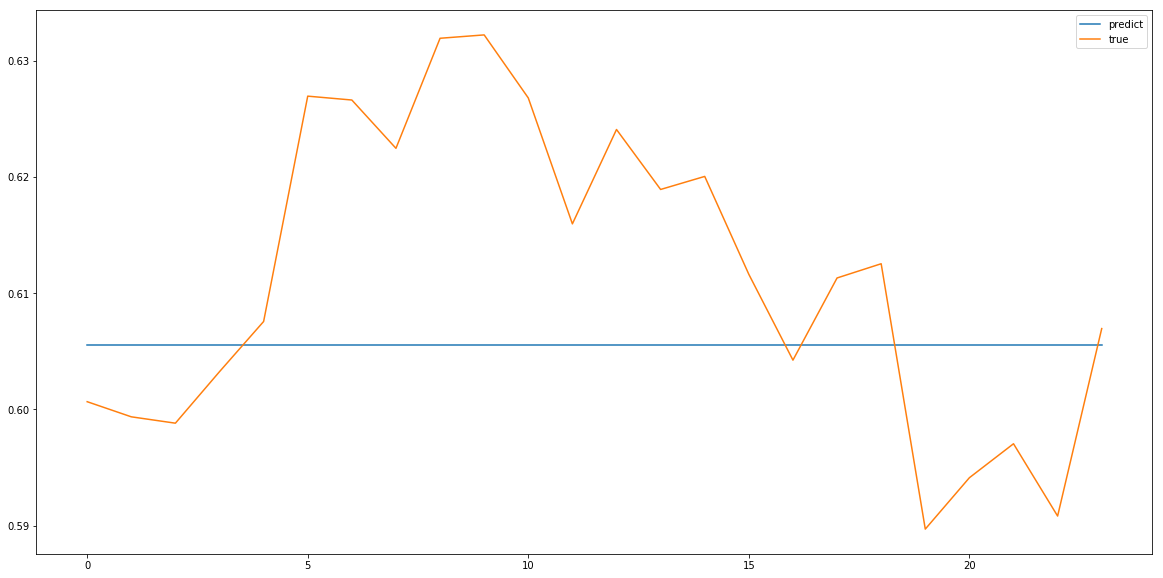

Test RMSE: 0.01413
Test MAE: 0.01185
Test MSE: 0.00020
Test RMSE: 537.17580
Test MAE: 450.64536


In [153]:
from matplotlib import pyplot
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[60]
testy=testY[60]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### CNN-LSTM

In [60]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [61]:
model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 168, 6)]          0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 168, 64)           1216      
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 168, 64)           8256      
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 168, 64)           4160      
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 168, 64)           12352     
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 168, 64)           8256      
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 168, 64)         

In [62]:
history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
78/79 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 00001: val_loss improved from inf to 0.00238, saving model to saved_weights\btc_cnnlstm_multistep.hdf5
79/79 [==============================] - 13s 164ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 2/200
78/79 [============================>.] - ETA: 0s - loss: 7.6193e-04
Epoch 00002: val_loss improved from 0.00238 to 0.00077, saving model to saved_weights\btc_cnnlstm_multistep.hdf5
79/79 [==============================] - 13s 158ms/step - loss: 7.6156e-04 - val_loss: 7.7336e-04
Epoch 3/200
78/79 [============================>.] - ETA: 0s - loss: 4.6939e-04
Epoch 00003: val_loss did not improve from 0.00077
79/79 [==============================] - 13s 158ms/step - loss: 4.6908e-04 - val_loss: 0.0011
Epoch 4/200
78/79 [============================>.] - ETA: 0s - loss: 3.4197e-04
Epoch 00004: val_loss did not improve from 0.00077
79/79 [==============================] - 13s 159ms/step - loss: 3.4185e-04 - v

KeyboardInterrupt: 

In [63]:
model.load_weights("saved_weights/btc_cnnlstm_multistep.hdf5")

In [65]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

(1, 168, 6)


C:\Users\chlgy\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\chlgy\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 720x720 with 0 Axes>

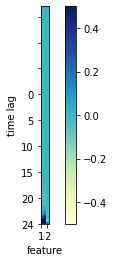

In [68]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[5], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(10,10))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 168]
#x_label_list = [1,2,3,4,5,6,7,8,9]
#y_label_list = [24,20,15,10,5,0]
#ax.set_yticks([0,5,10,15,20,24])

#ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6, 0 , 168], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


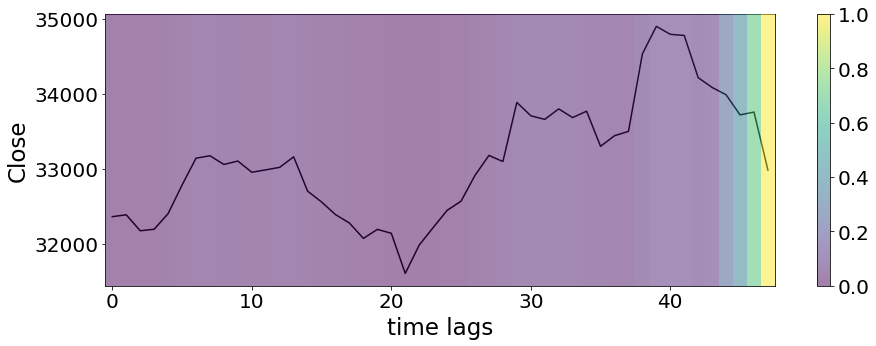

In [67]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

In [407]:
len(testX)/24

38.708333333333336

In [23]:
import random
##133,106,130,143,111,172

    #print(i,random.randint(0,37))
j=np.random.choice(38,15,replace=False).tolist()

In [38]:
j=[12, 4, 0, 26, 29, 5, 31, 30, 24, 14, 10, 13, 19, 32, 3]

In [39]:
from math import *
from sklearn.metrics import *

non_aug_rm=[]
non_aug_ma=[]
non_aug_mp=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    
    mae = mean_absolute_error(testy, yhat)
    
    mape=mean_absolute_percentage_error(testy, np.array(yhat))
    print('Test MAPE: %.5f' % mape)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    non_aug_rm.append(rmse)
    non_aug_ma.append(mae)
    non_aug_mp.append(mape)


print(np.mean(non_aug_rm),np.std(non_aug_rm))
print(np.mean(non_aug_ma),np.std(non_aug_ma))
print(np.mean(non_aug_mp),np.std(non_aug_mp))

Test MAPE: 0.06181
Test MAE: 0.04551
Test RMSE: 0.04799
Test MAPE: 0.01063
Test MAE: 0.00645
Test RMSE: 0.00848
Test MAPE: 0.01225
Test MAE: 0.00624
Test RMSE: 0.00746
Test MAPE: 0.05588
Test MAE: 0.04866
Test RMSE: 0.04990
Test MAPE: 0.02037
Test MAE: 0.01484
Test RMSE: 0.01918
Test MAPE: 0.01510
Test MAE: 0.00919
Test RMSE: 0.01077
Test MAPE: 0.06049
Test MAE: 0.04575
Test RMSE: 0.04655
Test MAPE: 0.07172
Test MAE: 0.05504
Test RMSE: 0.05682
Test MAPE: 0.03214
Test MAE: 0.02777
Test RMSE: 0.03212
Test MAPE: 0.10094
Test MAE: 0.08822
Test RMSE: 0.09335
Test MAPE: 0.11165
Test MAE: 0.08683
Test RMSE: 0.09092
Test MAPE: 0.11561
Test MAE: 0.09297
Test RMSE: 0.09658
Test MAPE: 0.06951
Test MAE: 0.05752
Test RMSE: 0.06609
Test MAPE: 0.04861
Test MAE: 0.03755
Test RMSE: 0.04196
Test MAPE: 0.08948
Test MAE: 0.05432
Test RMSE: 0.05803
0.04841354416323031 0.028842124768853405
0.045123722 0.02805854
0.058412544 0.034376577


In [25]:
from math import *
from sklearn.metrics import *

non_aug_rm=[]
non_aug_ma=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    non_aug_rm.append(rmse)
    non_aug_ma.append(mae)


print(np.mean(non_aug_rm))
print(np.mean(non_aug_ma))

Test MAE: 0.01689
Test RMSE: 0.02160
Test MAE: 0.01176
Test RMSE: 0.01384
Test MAE: 0.01237
Test RMSE: 0.01422
Test MAE: 0.00934
Test RMSE: 0.01158
Test MAE: 0.02457
Test RMSE: 0.02911
Test MAE: 0.00917
Test RMSE: 0.01101
Test MAE: 0.01970
Test RMSE: 0.02146
Test MAE: 0.02795
Test RMSE: 0.03094
Test MAE: 0.02996
Test RMSE: 0.03682
Test MAE: 0.05149
Test RMSE: 0.05952
Test MAE: 0.05432
Test RMSE: 0.06056
Test MAE: 0.06799
Test RMSE: 0.07267
Test MAE: 0.04049
Test RMSE: 0.04629
Test MAE: 0.01882
Test RMSE: 0.02327
Test MAE: 0.04686
Test RMSE: 0.05107
0.03359789961338763
0.029446183


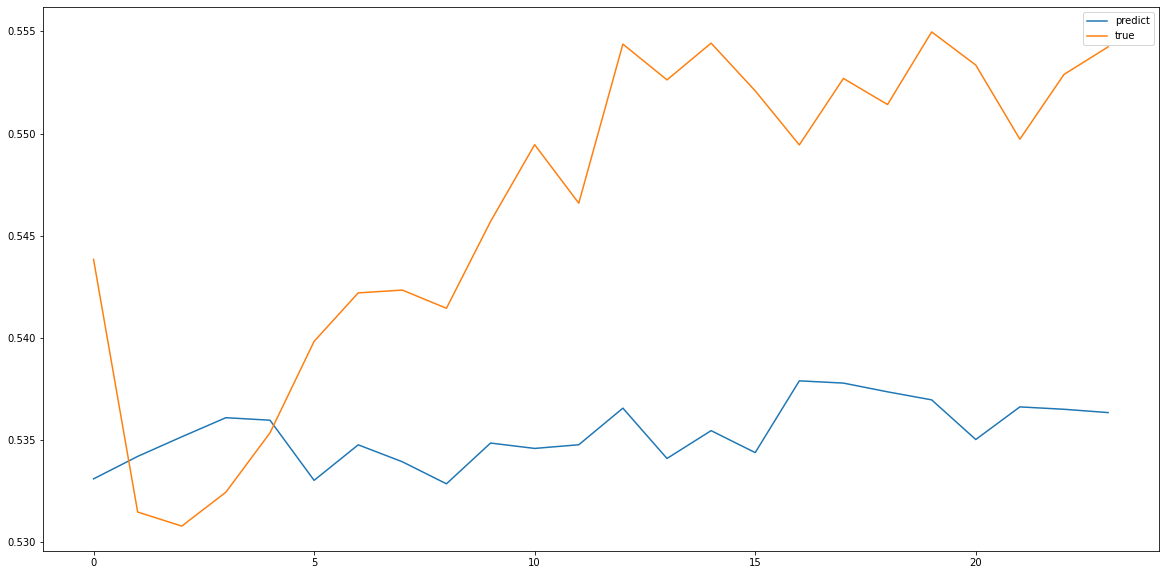

Test RMSE: 0.01320
Test MAE: 0.01200
Test MSE: 0.00017
Test RMSE: 501.81974
Test MAE: 456.05331


In [34]:


from matplotlib import pyplot
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*2]
testy=testY[24*2]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [35]:
d=pd.DataFrame()
d['yhat_inverse']=yhat_inverse.reshape(1,-1)[0]
d.to_excel('btc_cnnlstm_predict.xlsx')

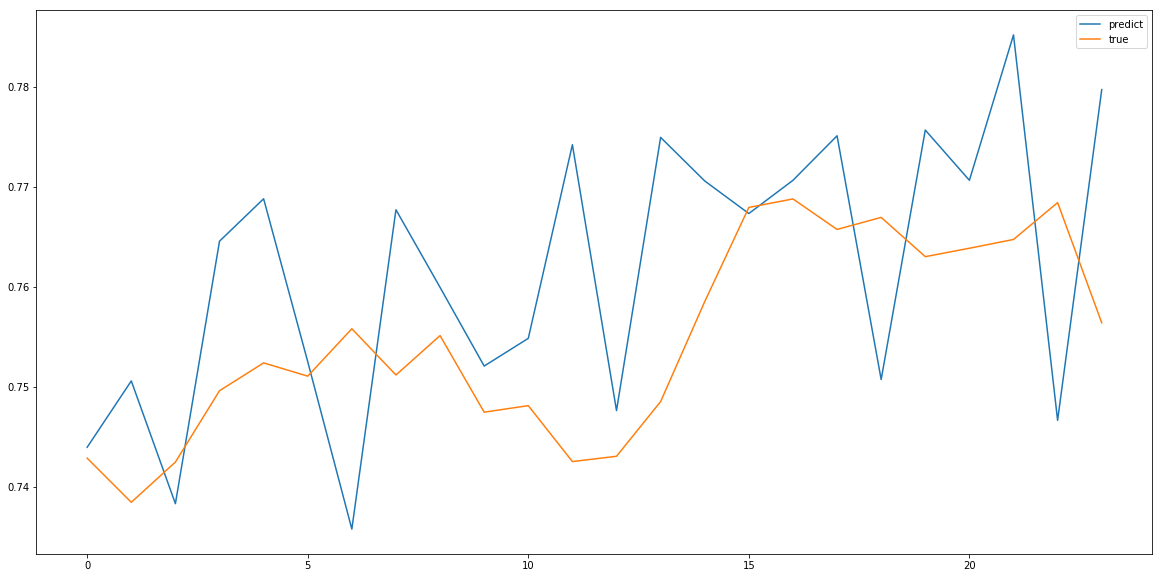

Test RMSE: 0.01485
Test MAE: 0.01212
Test MSE: 0.00022
Test RMSE: 564.66893
Test MAE: 460.69083


In [422]:
from matplotlib import pyplot
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*31]
testy=testY[24*31]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [301]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [14]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

(1, 48, 4)


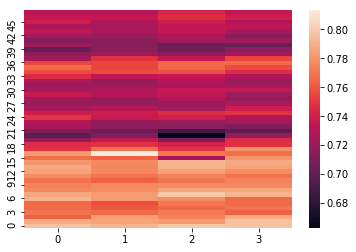

conv1d_101/kernel:0 (5, 4, 64)
[[[-0. -0. -0. ... -0.  0.  0.]
  [ 0. -0.  0. ... -0.  0. -0.]
  [ 0. -0.  0. ...  0.  0. -0.]
  [-0. -0. -0. ... -0.  0. -0.]]

 [[-0.  0. -0. ... -0.  0. -0.]
  [ 0. -0.  0. ...  0.  0.  0.]
  [-0. -0.  0. ...  0.  0.  0.]
  [-0.  0.  0. ... -0.  0. -0.]]

 [[ 0. -0.  0. ... -0. -0.  0.]
  [-0.  0.  0. ...  0. -0. -0.]
  [ 0. -0.  0. ...  0.  0.  0.]
  [-0.  0.  0. ...  0. -0.  0.]]

 [[ 0.  0.  0. ...  0. -0. -0.]
  [ 0.  0. -0. ...  0.  0. -0.]
  [ 0. -0. -0. ... -0.  0. -0.]
  [ 0. -0.  0. ... -0. -0. -0.]]

 [[ 0.  0.  0. ... -0.  0. -0.]
  [ 0. -0.  0. ...  0. -0.  0.]
  [-0. -0.  0. ... -0.  0. -0.]
  [-0. -0.  0. ...  0. -0. -0.]]]
conv1d_101/bias:0 (64,)
[-0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0.
  0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0.
  0. -0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.
 -0. -0.  0.  0. -0.  0. -0. -0. -0.  0.]
conv1d_102/kernel:0 (1, 64, 64)
[[

In [418]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = 24*13
output_final = model.predict(np.array([testX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
output = intermediate_layer_model.predict(np.array([testX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.gca().invert_yaxis()
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

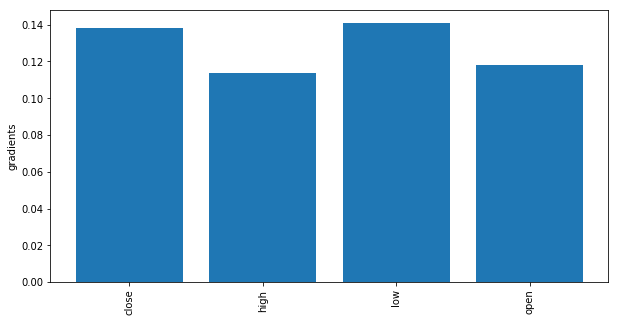

In [419]:
columns='close','high','low','open'
X_test=testX.copy()
id_=24*13
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

(1, 48, 4)


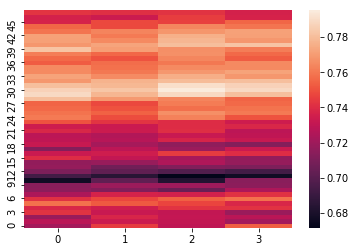

conv1d_101/kernel:0 (5, 4, 64)
[[[-0. -0. -0. ... -0.  0.  0.]
  [ 0. -0.  0. ... -0.  0. -0.]
  [ 0. -0.  0. ...  0.  0. -0.]
  [-0. -0. -0. ... -0.  0. -0.]]

 [[-0.  0. -0. ... -0.  0. -0.]
  [ 0. -0.  0. ...  0.  0.  0.]
  [-0. -0.  0. ...  0.  0.  0.]
  [-0.  0.  0. ... -0.  0. -0.]]

 [[ 0. -0.  0. ... -0. -0.  0.]
  [-0.  0.  0. ...  0. -0. -0.]
  [ 0. -0.  0. ...  0.  0.  0.]
  [-0.  0.  0. ...  0. -0.  0.]]

 [[ 0.  0.  0. ...  0. -0. -0.]
  [ 0.  0. -0. ...  0.  0. -0.]
  [ 0. -0. -0. ... -0.  0. -0.]
  [ 0. -0.  0. ... -0. -0. -0.]]

 [[ 0.  0.  0. ... -0.  0. -0.]
  [ 0. -0.  0. ...  0. -0.  0.]
  [-0. -0.  0. ... -0.  0. -0.]
  [-0. -0.  0. ...  0. -0. -0.]]]
conv1d_101/bias:0 (64,)
[-0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0.
  0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0.
  0. -0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.
 -0. -0.  0.  0. -0.  0. -0. -0. -0.  0.]
conv1d_102/kernel:0 (1, 64, 64)
[[

In [423]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = 24*31
output_final = model.predict(np.array([testX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
output = intermediate_layer_model.predict(np.array([testX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.gca().invert_yaxis()
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

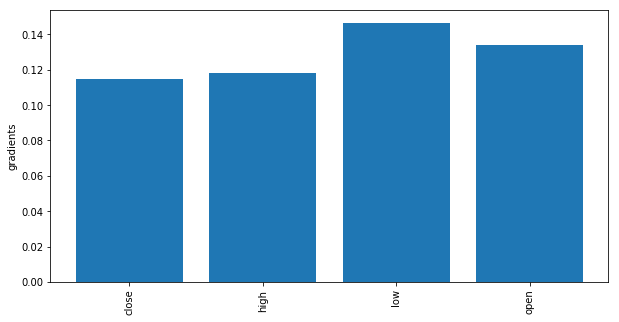

In [424]:
columns='close','high','low','open'
X_test=testX.copy()
id_=24*31
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [420]:
id_=24*13

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

#X_test[id_][:,0].shape

array([34216., 33906., 32952., 33204., 33078., 33067., 34048., 33898.,
       33451., 33364., 33168., 33521., 33810., 33877., 33631., 33132.,
       33660., 32394., 32339., 31269., 30527., 31021., 31524., 31674.,
       32428., 32036., 31570., 31250., 31440., 31949., 31535., 31293.,
       31620., 32310., 32714., 33094., 32636., 31473., 31155., 30678.,
       31399., 31083., 31467., 31847., 31619., 32083., 31905., 31769.],
      dtype=float32)

In [33]:
id_=24*26

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([37616., 37880., 37616., 37303., 36908., 36775., 37120., 36317.,
       36516., 36387., 36768., 37082., 36791., 36571., 36225., 35922.,
       35756., 35092., 35037., 34474., 35186., 35645., 35472., 35192.,
       35122., 36084., 36273., 36178., 36040., 36000., 36437., 36912.,
       36553., 36197., 36331., 36489., 36117., 35430., 35469., 35713.,
       35531., 36469., 36588., 36910., 36578., 36797., 37404., 37169.],
      dtype=float32)

In [35]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

[2.e-01 1.e-01 6.e-02 5.e-02 5.e-02 4.e-02 4.e-02 4.e-02 3.e-02 3.e-02
 3.e-02 4.e-02 4.e-02 3.e-02 3.e-02 2.e-02 2.e-02 1.e-02 2.e-03 0.e+00
 1.e-03 4.e-03 1.e-02 1.e-02 1.e-02 1.e-02 2.e-02 3.e-02 2.e-02 2.e-02
 3.e-02 3.e-02 3.e-02 4.e-02 3.e-02 3.e-02 3.e-02 2.e-02 2.e-02 1.e-02
 1.e-02 2.e-02 3.e-02 4.e-02 4.e-02 6.e-02 5.e-01 1.e+00]


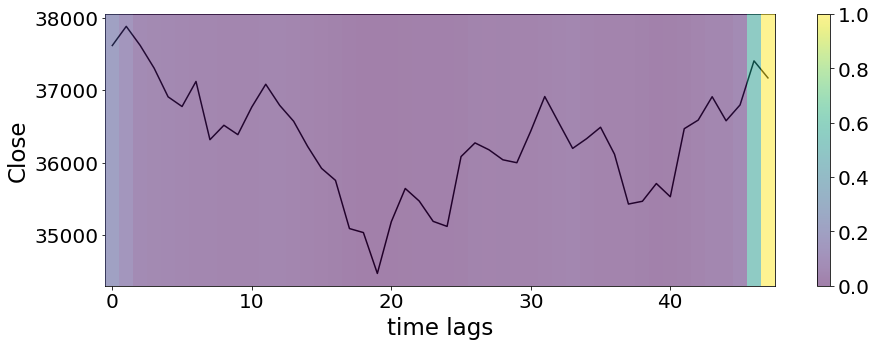

In [36]:
from scipy.ndimage import zoom
import random
import pylab

id_=24*26


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


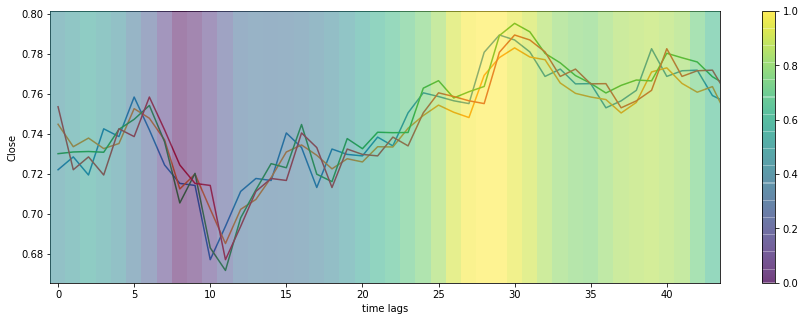

In [426]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

#plt.plot(testX_inverse, 'k')
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

### time distributed cnn-lstm

In [87]:
from tensorflow.keras.models import Model

first_input = Input(shape=(None,12,4))

#in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
in1=LSTM(units =150 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(6, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_timecnnlstm_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [89]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None, 12, 4)]     0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, None, 8, 64)       1344      
_________________________________________________________________
time_distributed_52 (TimeDis (None, None, 8, 64)       4160      
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, None, 256)         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 150)               244200    
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 906

In [40]:
history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7986 samples, validate on 982 samples
Epoch 1/500
6700/7986 [========================>.....] - ETA: 0s - loss: 0.0051
Epoch 00001: val_loss improved from inf to 0.02554, saving model to saved_weights/btc_timecnnlstm_multistep.hdf5
7986/7986 [==============================] - 2s 225us/sample - loss: 0.0049 - val_loss: 0.0255
Epoch 2/500
7900/7986 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 00002: val_loss did not improve from 0.02554
7986/7986 [==============================] - 0s 43us/sample - loss: 0.0037 - val_loss: 0.0256
Epoch 3/500
6700/7986 [========================>.....] - ETA: 0s - loss: 0.0037
Epoch 00003: val_loss did not improve from 0.02554
7986/7986 [==============================] - 0s 43us/sample - loss: 0.0037 - val_loss: 0.0256
Epoch 4/500
7900/7986 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 00004: val_loss did not improve from 0.02554
7986/7986 [==============================] - 0s 43us/sample - loss: 0.0037 - val_los

7986/7986 [==============================] - 1s 74us/sample - loss: 1.6142e-05 - val_loss: 7.1436e-05
Epoch 35/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.4698e-05
Epoch 00035: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.4138e-05 - val_loss: 8.0959e-05
Epoch 36/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.3766e-05
Epoch 00036: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.3854e-05 - val_loss: 7.3124e-05
Epoch 37/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.5160e-05
Epoch 00037: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.5410e-05 - val_loss: 1.3634e-04
Epoch 38/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.3945e-05
Epoch 00038: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 

Epoch 69/500
6600/7986 [=======================>......] - ETA: 0s - loss: 1.2099e-05
Epoch 00069: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.2372e-05 - val_loss: 1.3837e-04
Epoch 70/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.3789e-05
Epoch 00070: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.3627e-05 - val_loss: 1.7771e-04
Epoch 71/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.3092e-05
Epoch 00071: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.2824e-05 - val_loss: 1.0049e-04
Epoch 72/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.3189e-05
Epoch 00072: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.2850e-05 - val_loss: 2.5667e-04
Epoch 73/500
6800/7986 [========================

Epoch 104/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.1699e-05
Epoch 00104: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.1543e-05 - val_loss: 1.6466e-04
Epoch 105/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.1414e-05
Epoch 00105: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.1193e-05 - val_loss: 1.4152e-04
Epoch 106/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.0522e-05
Epoch 00106: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0503e-05 - val_loss: 1.0180e-04
Epoch 107/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.1267e-05
Epoch 00107: val_loss did not improve from 0.00007
7986/7986 [==============================] - 0s 42us/sample - loss: 1.1769e-05 - val_loss: 1.4553e-04
Epoch 108/500
6600/7986 [===================

Epoch 172/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.2233e-05
Epoch 00172: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.1904e-05 - val_loss: 1.8480e-04
Epoch 173/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.0642e-05
Epoch 00173: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0527e-05 - val_loss: 9.3260e-05
Epoch 174/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.0835e-05
Epoch 00174: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0577e-05 - val_loss: 1.4918e-04
Epoch 175/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.0963e-05
Epoch 00175: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0734e-05 - val_loss: 8.2330e-05
Epoch 176/500
6700/7986 [===================

6800/7986 [========================>.....] - ETA: 0s - loss: 9.9334e-06
Epoch 00240: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0049e-05 - val_loss: 2.2943e-04
Epoch 241/500
6800/7986 [========================>.....] - ETA: 0s - loss: 1.0545e-05
Epoch 00241: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0425e-05 - val_loss: 1.1801e-04
Epoch 242/500
6700/7986 [========================>.....] - ETA: 0s - loss: 1.0018e-05
Epoch 00242: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.7577e-06 - val_loss: 1.3559e-04
Epoch 243/500
6600/7986 [=======================>......] - ETA: 0s - loss: 1.0708e-05
Epoch 00243: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0672e-05 - val_loss: 1.8509e-04
Epoch 244/500
6800/7986 [========================>.....] -

6900/7986 [========================>.....] - ETA: 0s - loss: 1.0465e-05
Epoch 00308: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0402e-05 - val_loss: 1.1065e-04
Epoch 309/500
6800/7986 [========================>.....] - ETA: 0s - loss: 9.9336e-06
Epoch 00309: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.7095e-06 - val_loss: 1.0568e-04
Epoch 310/500
6800/7986 [========================>.....] - ETA: 0s - loss: 9.6700e-06
Epoch 00310: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.5925e-06 - val_loss: 1.2249e-04
Epoch 311/500
6900/7986 [========================>.....] - ETA: 0s - loss: 9.7204e-06
Epoch 00311: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.8197e-06 - val_loss: 1.4421e-04
Epoch 312/500
6700/7986 [========================>.....] -

6800/7986 [========================>.....] - ETA: 0s - loss: 9.5428e-06
Epoch 00376: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.6502e-06 - val_loss: 2.0409e-04
Epoch 377/500
6900/7986 [========================>.....] - ETA: 0s - loss: 9.0711e-06
Epoch 00377: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.0851e-06 - val_loss: 1.8303e-04
Epoch 378/500
6800/7986 [========================>.....] - ETA: 0s - loss: 9.6231e-06
Epoch 00378: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.7896e-06 - val_loss: 2.4812e-04
Epoch 379/500
6900/7986 [========================>.....] - ETA: 0s - loss: 1.0376e-05
Epoch 00379: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 1.0342e-05 - val_loss: 1.8926e-04
Epoch 380/500
6800/7986 [========================>.....] -

7900/7986 [============================>.] - ETA: 0s - loss: 9.2694e-06
Epoch 00444: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.2509e-06 - val_loss: 1.6498e-04
Epoch 445/500
6800/7986 [========================>.....] - ETA: 0s - loss: 9.3378e-06
Epoch 00445: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.3273e-06 - val_loss: 2.4092e-04
Epoch 446/500
6800/7986 [========================>.....] - ETA: 0s - loss: 9.1281e-06
Epoch 00446: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.1103e-06 - val_loss: 1.7069e-04
Epoch 447/500
6900/7986 [========================>.....] - ETA: 0s - loss: 9.0630e-06
Epoch 00447: val_loss did not improve from 0.00006
7986/7986 [==============================] - 0s 42us/sample - loss: 9.0612e-06 - val_loss: 2.0641e-04
Epoch 448/500
6700/7986 [========================>.....] -

In [88]:
model.load_weights("saved_weights/btc_timecnnlstm_multistep.hdf5")

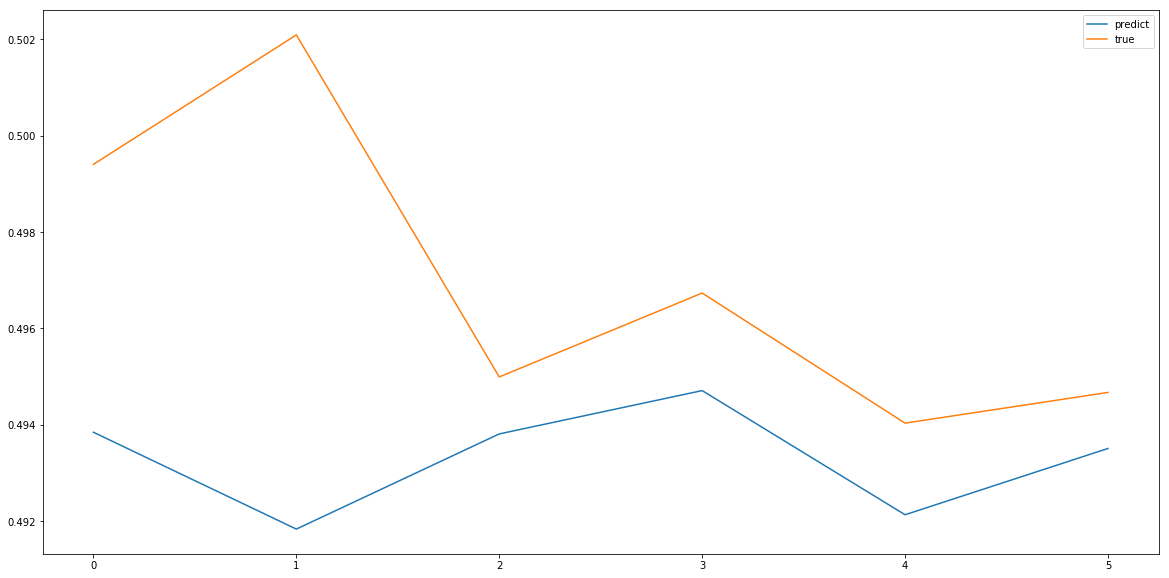

Test RMSE: 0.00494
Test MAE: 0.00368
Test MSE: 0.00002
Test RMSE: 187.83060
Test MAE: 139.89778


In [86]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[1]
testy=testY[1]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [95]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

(1, 1, 256)


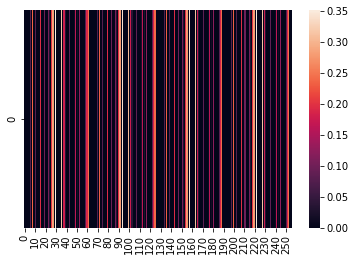

time_distributed_51/kernel:0 (5, 4, 64)
[[[ 0.01678235 -0.04083656  0.07425497 ...  0.00718983 -0.02793107
    0.01886117]
  [-0.0437188  -0.12975161  0.05761142 ...  0.10288694 -0.02052065
    0.07870948]
  [-0.07999055 -0.03935354 -0.01963523 ... -0.00111069 -0.02591384
   -0.00314414]
  [ 0.08206625  0.03965497 -0.0976927  ... -0.04722732  0.12011532
    0.12040696]]

 [[ 0.17279013 -0.12770483  0.04131999 ... -0.14796886 -0.00104999
    0.00563573]
  [-0.05483732 -0.08895819  0.00961388 ...  0.08749204  0.03389324
   -0.01902654]
  [ 0.13265564 -0.06965794  0.07514199 ...  0.03799227 -0.04097556
    0.12918164]
  [ 0.03895969  0.06524608 -0.05908101 ...  0.04014428  0.03083405
    0.09413714]]

 [[-0.07936572 -0.05098992  0.07503597 ...  0.02361978  0.12024573
   -0.08278485]
  [ 0.12637946 -0.01857468  0.08068655 ...  0.02167341 -0.09020348
   -0.05931532]
  [-0.10248226  0.03049579 -0.01786126 ... -0.08445031 -0.04625495
   -0.07235264]
  [ 0.00070043 -0.03532042 -0.03487537 ... 

In [103]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = 295
output_final = model.predict(np.array([valX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[4].output)
output = intermediate_layer_model.predict(np.array([valX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

### Timedistributed LSTM-CNN

In [85]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [23]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,12,4))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

in0=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu',padding='same'))(in1)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in0)

#in1=add([in0,in1])
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#in1=RepeatVector(7)(in1)

#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =150 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
in1=TimeDistributed(Dense(1, activation = 'relu'))(in1)

model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_timelstmcnn15051_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


ValueError: Input 0 of layer repeat_vector_1 is incompatible with the layer: expected ndim=2, found ndim=3. Full shape received: [None, None, 1]

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 12, 4)]     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 12, 150)     93000     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 12, 64)      48064     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 12, 64)      4160      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 6, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 384)         0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1)           385 

In [15]:
## timedistribute lstm(100)-1dcnn

history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7986 samples, validate on 982 samples
Epoch 1/500
7800/7986 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00047, saving model to saved_weights/btc_timelstmcnn15051_mulstep.hdf5
7986/7986 [==============================] - 3s 332us/sample - loss: 0.0011 - val_loss: 4.6638e-04
Epoch 2/500
7800/7986 [============================>.] - ETA: 0s - loss: 2.5190e-05
Epoch 00002: val_loss improved from 0.00047 to 0.00025, saving model to saved_weights/btc_timelstmcnn15051_mulstep.hdf5
7986/7986 [==============================] - 1s 136us/sample - loss: 2.5503e-05 - val_loss: 2.5420e-04
Epoch 3/500
7700/7986 [===========================>..] - ETA: 0s - loss: 2.6380e-05
Epoch 00003: val_loss improved from 0.00025 to 0.00019, saving model to saved_weights/btc_timelstmcnn15051_mulstep.hdf5
7986/7986 [==============================] - 1s 135us/sample - loss: 2.6204e-05 - val_loss: 1.9047e-04
Epoch 4/500
7600/7986 [=====================

7986/7986 [==============================] - 1s 138us/sample - loss: 2.2485e-05 - val_loss: 1.1550e-04
Epoch 32/500
7600/7986 [===========================>..] - ETA: 0s - loss: 2.2610e-05
Epoch 00032: val_loss did not improve from 0.00012
7986/7986 [==============================] - 1s 133us/sample - loss: 2.2506e-05 - val_loss: 1.2865e-04
Epoch 33/500
7900/7986 [============================>.] - ETA: 0s - loss: 2.3352e-05
Epoch 00033: val_loss did not improve from 0.00012
7986/7986 [==============================] - 1s 134us/sample - loss: 2.3258e-05 - val_loss: 1.3098e-04
Epoch 34/500
7600/7986 [===========================>..] - ETA: 0s - loss: 2.2798e-05
Epoch 00034: val_loss did not improve from 0.00012
7986/7986 [==============================] - 1s 134us/sample - loss: 2.2933e-05 - val_loss: 1.2149e-04
Epoch 35/500
7900/7986 [============================>.] - ETA: 0s - loss: 2.2246e-05
Epoch 00035: val_loss did not improve from 0.00012
7986/7986 [==============================] -

Epoch 65/500
7700/7986 [===========================>..] - ETA: 0s - loss: 2.0063e-05
Epoch 00065: val_loss did not improve from 0.00009
7986/7986 [==============================] - 1s 134us/sample - loss: 2.0277e-05 - val_loss: 1.4603e-04
Epoch 66/500
7700/7986 [===========================>..] - ETA: 0s - loss: 1.9787e-05
Epoch 00066: val_loss did not improve from 0.00009
7986/7986 [==============================] - 1s 133us/sample - loss: 1.9861e-05 - val_loss: 1.0182e-04
Epoch 67/500
7700/7986 [===========================>..] - ETA: 0s - loss: 2.0718e-05
Epoch 00067: val_loss did not improve from 0.00009
7986/7986 [==============================] - 1s 134us/sample - loss: 2.0976e-05 - val_loss: 1.3947e-04
Epoch 68/500
7700/7986 [===========================>..] - ETA: 0s - loss: 2.1104e-05
Epoch 00068: val_loss did not improve from 0.00009
7986/7986 [==============================] - 1s 133us/sample - loss: 2.1072e-05 - val_loss: 1.0448e-04
Epoch 69/500
7800/7986 [====================

7700/7986 [===========================>..] - ETA: 0s - loss: 1.8488e-05
Epoch 00130: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.8471e-05 - val_loss: 9.2784e-05
Epoch 131/500
7700/7986 [===========================>..] - ETA: 0s - loss: 1.8607e-05
Epoch 00131: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.8539e-05 - val_loss: 9.6265e-05
Epoch 132/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.9530e-05
Epoch 00132: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.9519e-05 - val_loss: 9.3411e-05
Epoch 133/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.8748e-05
Epoch 00133: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.8985e-05 - val_loss: 9.9769e-05
Epoch 134/500
7900/7986 [============================>

Epoch 197/500
7500/7986 [===========================>..] - ETA: 0s - loss: 1.8813e-05
Epoch 00197: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 133us/sample - loss: 1.8773e-05 - val_loss: 9.3912e-05
Epoch 198/500
7900/7986 [============================>.] - ETA: 0s - loss: 1.8048e-05
Epoch 00198: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.8024e-05 - val_loss: 9.3319e-05
Epoch 199/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.7961e-05
Epoch 00199: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.7918e-05 - val_loss: 8.7191e-05
Epoch 200/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.8122e-05
Epoch 00200: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.8142e-05 - val_loss: 1.1485e-04
Epoch 201/500
7600/7986 [===============

Epoch 265/500
7900/7986 [============================>.] - ETA: 0s - loss: 1.8386e-05
Epoch 00265: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 133us/sample - loss: 1.8376e-05 - val_loss: 8.6340e-05
Epoch 266/500
7900/7986 [============================>.] - ETA: 0s - loss: 1.6990e-05
Epoch 00266: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.7027e-05 - val_loss: 8.3781e-05
Epoch 267/500
7900/7986 [============================>.] - ETA: 0s - loss: 1.8218e-05
Epoch 00267: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.8209e-05 - val_loss: 1.0220e-04
Epoch 268/500
7600/7986 [===========================>..] - ETA: 0s - loss: 1.8037e-05
Epoch 00268: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.7945e-05 - val_loss: 1.1432e-04
Epoch 269/500
7700/7986 [===============

Epoch 333/500
7700/7986 [===========================>..] - ETA: 0s - loss: 1.7350e-05
Epoch 00333: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 133us/sample - loss: 1.7388e-05 - val_loss: 8.6038e-05
Epoch 334/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.6648e-05
Epoch 00334: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.6815e-05 - val_loss: 1.0786e-04
Epoch 335/500
7900/7986 [============================>.] - ETA: 0s - loss: 1.7958e-05
Epoch 00335: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.7919e-05 - val_loss: 8.2076e-05
Epoch 336/500
7700/7986 [===========================>..] - ETA: 0s - loss: 1.6815e-05
Epoch 00336: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.6701e-05 - val_loss: 8.5914e-05
Epoch 337/500
7700/7986 [===============

7800/7986 [============================>.] - ETA: 0s - loss: 1.6660e-05
Epoch 00401: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.6825e-05 - val_loss: 1.4444e-04
Epoch 402/500
7500/7986 [===========================>..] - ETA: 0s - loss: 1.6543e-05
Epoch 00402: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 133us/sample - loss: 1.6974e-05 - val_loss: 9.5212e-05
Epoch 403/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.6852e-05
Epoch 00403: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.6893e-05 - val_loss: 1.0284e-04
Epoch 404/500
7900/7986 [============================>.] - ETA: 0s - loss: 1.6573e-05
Epoch 00404: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.6521e-05 - val_loss: 9.5223e-05
Epoch 405/500
7700/7986 [===========================>.

7700/7986 [===========================>..] - ETA: 0s - loss: 1.6508e-05
Epoch 00469: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.6516e-05 - val_loss: 1.1263e-04
Epoch 470/500
7800/7986 [============================>.] - ETA: 0s - loss: 1.6853e-05
Epoch 00470: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.6920e-05 - val_loss: 9.3278e-05
Epoch 471/500
7600/7986 [===========================>..] - ETA: 0s - loss: 1.7238e-05
Epoch 00471: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 134us/sample - loss: 1.7383e-05 - val_loss: 9.5965e-05
Epoch 472/500
7600/7986 [===========================>..] - ETA: 0s - loss: 1.6702e-05
Epoch 00472: val_loss did not improve from 0.00008
7986/7986 [==============================] - 1s 135us/sample - loss: 1.6619e-05 - val_loss: 1.0536e-04
Epoch 473/500
7600/7986 [===========================>.

In [16]:
model.load_weights("saved_weights/btc_timelstmcnn15051_mulstep.hdf5")

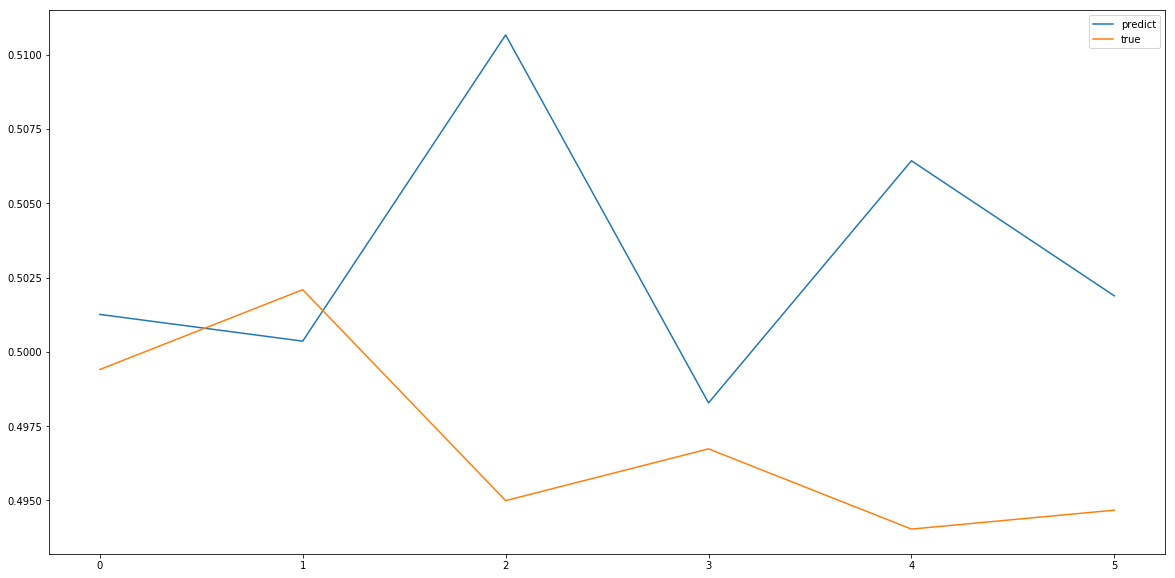

Test RMSE: 0.00876
Test MAE: 0.00673
Test MSE: 0.00008
Test RMSE: 332.83607
Test MAE: 256.00586


In [17]:

## timedistributed lstm150-1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[1]
testy=testY[1]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### visualize

In [89]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

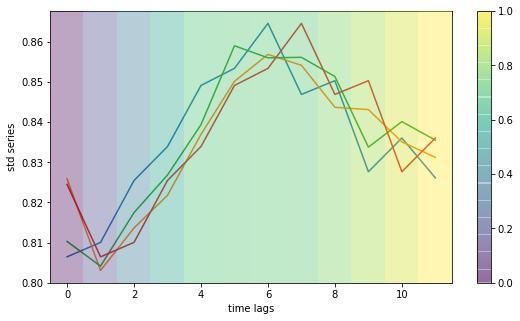

In [94]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

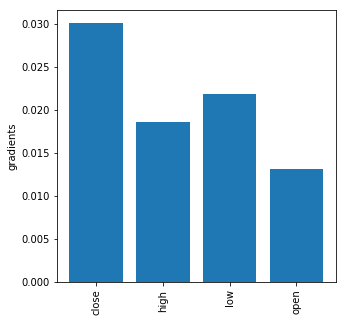

In [92]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)